In [19]:
# -*- coding: utf-8 -*-
import json
import numpy as np
import pandas as pd
from pathlib import Path
from collections import defaultdict, deque

# =============================================================================
# CONFIG (relative paths)
# =============================================================================
GRAPH_JSON_PATH = Path("src/data/raw/graph/whole_graph.json")
PRED_DIR        = Path("src/data/pred_normalized")  # enthält *_pred.csv

TS_COL      = "timestamp"
PRED_COL    = "P_MW_pred_norm"
PRED_SUFFIX = "_pred.csv"

S_BASE_MVA   = 100.0
V_KV_DEFAULT = 110.0
COSPHI_MIN   = 0.95

FORECAST_NODE_TYPES = {"uw_field"}
IGNORE_NODE_TYPES   = {"battery", "BESS", "Battery"}

NO_MEASURE_TYPES = {"Sammelschiene", "Leitungsknoten", "junction", "busbar"}

CONTRACT_ZERO_X = True

# Zeithorizont: zum Testen nur ein Timestamp; später N_TIMESTEPS erhöhen
T_TARGET   = "2025-12-08 06:00:00"   # z.B. "2026-01-11 17:45:00" oder None (= erster Timestamp)
N_TIMESTEPS = 1     # später z.B. 100

# >>> NEU: Slack fixieren (wenn vorhanden in Komponente), sonst Fallback Heuristik
FIXED_SLACK_NODE = "SHUW"

# >>> NEU: Bilanz-Mismatch vor Slack-Korrektur loggen
LOG_MISMATCH = True
# =============================================================================


# =============================================================================
# Helpers
# =============================================================================
def edge_raw_X_ohm(efeat: dict):
    for k in ("X_total_ohm", "X_Total_Ohm"):
        if efeat.get(k) not in (None, ""):
            return float(efeat[k])
    return None

def ohm_to_pu(X_ohm, V_kV, S_base_MVA):
    Zb = (V_kV * 1e3) ** 2 / (S_base_MVA * 1e6)
    return X_ohm / Zb

def mw_to_amp_with_pf(P_MW, V_kV, cosphi_min=COSPHI_MIN):
    if V_kV is None or V_kV <= 0:
        V_kV = V_KV_DEFAULT
    if cosphi_min <= 0 or cosphi_min > 1:
        raise ValueError("cosφ_min in (0,1] erwartet")
    P_W = abs(P_MW) * 1e6
    U_V = V_kV * 1e3
    return P_W / (np.sqrt(3.0) * U_V * cosphi_min)

class UF:
    def __init__(self, items):
        self.parent = {x: x for x in items}
        self.rank = {x: 0 for x in items}
    def find(self, x):
        p = self.parent[x]
        if p != x:
            self.parent[x] = self.find(p)
        return self.parent[x]
    def union(self, a, b):
        ra, rb = self.find(a), self.find(b)
        if ra == rb:
            return
        if self.rank[ra] < self.rank[rb]:
            self.parent[ra] = rb
        elif self.rank[ra] > self.rank[rb]:
            self.parent[rb] = ra
        else:
            self.parent[rb] = ra
            self.rank[ra] += 1

def connected_components(nodes, lines):
    idx = {n: i for i, n in enumerate(nodes)}
    adj = [[] for _ in nodes]
    for (u, v, *_) in lines:
        ui, vi = idx[u], idx[v]
        adj[ui].append(vi)
        adj[vi].append(ui)
    seen = [False] * len(nodes)
    comps = []
    for i in range(len(nodes)):
        if seen[i]:
            continue
        q = deque([i])
        seen[i] = True
        comp = []
        while q:
            x = q.popleft()
            comp.append(nodes[x])
            for y in adj[x]:
                if not seen[y]:
                    seen[y] = True
                    q.append(y)
        comps.append(comp)
    return comps

def choose_slack_for_component(component_nodes, lines, node_types, fixed_slack=FIXED_SLACK_NODE):
    # 1) Fixed slack, wenn in Komponente vorhanden
    if fixed_slack in component_nodes:
        return fixed_slack

    # 2) Heuristik: höchster Grad
    deg = {n: 0 for n in component_nodes}
    for (u, v, *_) in lines:
        if u in deg and v in deg:
            deg[u] += 1
            deg[v] += 1
    return max(component_nodes, key=lambda n: deg[n])

def pretty_matrix(name, M, rows=None, cols=None, fmt="{: .6f}", maxn=8):
    r, c = M.shape
    rr = rows or [f"r{i}" for i in range(r)]
    cc = cols or [f"c{j}" for j in range(c)]
    print(f"\n--- {name}  [{r}x{c}] ---")
    take_r = min(r, maxn)
    take_c = min(c, maxn)
    header = ["{:>12}".format("")] + ["{:>12}".format(cc[j]) for j in range(take_c)]
    print(" ".join(header))
    for i in range(take_r):
        row = ["{:>12}".format(rr[i])] + ["{:>12}".format(fmt.format(M[i, j])) for j in range(take_c)]
        print(" ".join(row))
    if r > take_r or c > take_c:
        print("...")

def read_pred_series_for_node(pred_dir: Path, node_id: str):
    path = pred_dir / f"{node_id}{PRED_SUFFIX}"
    if not path.is_file():
        return None
    df = pd.read_csv(path)
    if TS_COL not in df.columns:
        raise ValueError(f"Zeitspalte '{TS_COL}' fehlt in {path}")
    if PRED_COL not in df.columns:
        raise ValueError(f"Forecast-Spalte '{PRED_COL}' fehlt in {path}")

    dt = pd.to_datetime(df[TS_COL], errors="coerce")
    mask = ~dt.isna()
    if not mask.any():
        raise ValueError(f"Alle Zeitstempel in {path} sind ungültig.")
    df = df.loc[mask].copy()
    dt = dt.loc[mask]
    df.index = dt

    s = pd.to_numeric(df[PRED_COL], errors="coerce").fillna(0.0)
    s.index.name = None
    s.name = node_id
    return s.sort_index()

# =============================================================================
# 1) Graph laden
# =============================================================================
if not GRAPH_JSON_PATH.is_file():
    raise FileNotFoundError(f"GRAPH_JSON_PATH nicht gefunden: {GRAPH_JSON_PATH.resolve()}")
if not PRED_DIR.is_dir():
    raise FileNotFoundError(f"PRED_DIR nicht gefunden: {PRED_DIR.resolve()}")

with GRAPH_JSON_PATH.open("r", encoding="utf-8") as f:
    graph = json.load(f)

nodes, edges = [], []
node_types, node_features = {}, {}
for it in graph:
    if "data" not in it:
        continue
    d = it["data"]
    if "source" in d and "target" in d:
        edges.append(d)
    else:
        nid = d["id"]
        nodes.append(nid)
        node_types[nid] = (d.get("type") or "").strip()
        node_features[nid] = d.get("features", {}) or {}

if not nodes:
    raise RuntimeError("Keine Knoten im Graph gefunden.")

print(f"=== Graph geladen ===\nKnoten: {len(nodes)} | Kanten: {len(edges)}")
print("Node-Type Counts:", pd.Series(list(node_types.values())).value_counts().to_dict())

# =============================================================================
# 2) Kanten-Preprocessing: Zero-X kontrahieren, elektrische Kanten behalten
# =============================================================================
uf = UF(nodes)
electrical_edges = []   # (u,v,eid,feat,Xohm)
visual_to_contract = [] # (u,v) ohne brauchbare X

for e in edges:
    u, v = e["source"], e["target"]
    feat = e.get("features", {}) or {}
    eid = e.get("id") or feat.get("id") or f"{u}-{v}"
    Xohm = edge_raw_X_ohm(feat)

    if Xohm is None or Xohm <= 0.0:
        if CONTRACT_ZERO_X:
            visual_to_contract.append((u, v))
    else:
        electrical_edges.append((u, v, eid, feat, Xohm))

for (u, v) in visual_to_contract:
    if u in node_types and v in node_types:
        uf.union(u, v)

rep_map = {nid: uf.find(nid) for nid in nodes}
super_nodes = sorted(set(rep_map.values()))

members_by_rep = defaultdict(list)
for nid, rep in rep_map.items():
    members_by_rep[rep].append(nid)

def merged_type(members):
    types = [node_types.get(m, "") for m in members if node_types.get(m, "")]
    for t in types:
        if t.lower() in {"bess", "battery"}:
            return "battery"
    return types[0] if types else ""

super_node_types = {rep: merged_type(members_by_rep[rep]) for rep in super_nodes}

super_edges = []  # (ru, rv, eid, feat, Xohm)
for (u, v, eid, feat, Xohm) in electrical_edges:
    ru, rv = rep_map[u], rep_map[v]
    if ru == rv:
        continue
    super_edges.append((ru, rv, eid, feat, Xohm))

if not super_edges:
    raise RuntimeError("Nach Kontraktion/Filterung keine elektrischen Kanten übrig.")

print(f"\n=== Supernetz ===\nSuperknoten: {len(super_nodes)} | Superkanten: {len(super_edges)}")

# =============================================================================
# 3) Forecast laden (nur uw_field) + Vorzeichen-Flip zu Injection-Konvention
#    Forecast: Last +, Einspeisung -  -->  Injection: Einspeisung +, Last -
#    => P_inj = - P_forecast
# =============================================================================
uw_fields = [n for n in nodes if node_types.get(n, "") in FORECAST_NODE_TYPES]
batteries = [n for n in nodes if node_types.get(n, "") in IGNORE_NODE_TYPES]

missing_pred = []
series_by_node = {}

for nid in uw_fields:
    s = read_pred_series_for_node(PRED_DIR, nid)
    if s is None:
        missing_pred.append(nid)
    else:
        series_by_node[nid] = (-s)  # SIGN FLIP

if not series_by_node:
    raise RuntimeError("Keine Forecast-Dateien für uw_field gefunden. Prüfe PRED_DIR und Dateinamen <NODE>_pred.csv")

P_df = pd.concat(list(series_by_node.values()), axis=1).sort_index()

# Alle Graph-Nodes als Spalten: fehlende => 0
for nid in nodes:
    if nid not in P_df.columns:
        P_df[nid] = 0.0

# battery explizit 0
for nid in batteries:
    P_df[nid] = 0.0

# Superknoten-Leistung = Summe der Mitgliedsleistungen
for rep, members in members_by_rep.items():
    cols = [c for c in members if c in P_df.columns]
    P_df[rep] = P_df[cols].sum(axis=1) if cols else 0.0

P_df = P_df[super_nodes].fillna(0.0)

print("\n=== Forecast-Input ===")
print(f"uw_field Nodes: {len(uw_fields)} | Forecast vorhanden: {len(series_by_node)} | Fehlend: {len(missing_pred)}")
if missing_pred:
    print("Fehlende Forecast-Dateien (werden als 0 MW behandelt):", missing_pred[:15], "..." if len(missing_pred) > 15 else "")
print(f"Zeitstempel verfügbar: {len(P_df)} | von {P_df.index.min()} bis {P_df.index.max()}")

# =============================================================================
# 4) B-Matrix (p.u.) bauen
# =============================================================================
n = len(super_nodes)
node_index = {nid: i for i, nid in enumerate(super_nodes)}
B = np.zeros((n, n), dtype=float)

lines = []  # (ru, rv, X_pu, eid, feat)
for (ru, rv, eid, feat, Xohm) in super_edges:
    X_pu = ohm_to_pu(Xohm, V_KV_DEFAULT, S_BASE_MVA)
    if X_pu <= 0:
        continue
    lines.append((ru, rv, X_pu, eid, feat))

if not lines:
    raise RuntimeError("Keine gültigen Leitungen mit X_pu > 0 im Supernetz.")

for (ru, rv, X_pu, eid, feat) in lines:
    i, j = node_index[ru], node_index[rv]
    b = 1.0 / X_pu
    B[i, j] -= b
    B[j, i] -= b
for i in range(n):
    B[i, i] = -np.sum(B[i, :])

pretty_matrix("B (nodale Suszeptanz, p.u.)", B, rows=super_nodes, cols=super_nodes)

# =============================================================================
# 5) Komponenten & Slack & Solver-Setup (KEIN inv mehr)
# =============================================================================
components = connected_components(super_nodes, lines)
print("\n=== Komponenten ===")
for comp in components:
    print(" ", comp)

slack_by_comp = {}
for comp in components:
    ck = frozenset(comp)
    slack_by_comp[ck] = choose_slack_for_component(comp, lines, super_node_types, fixed_slack=FIXED_SLACK_NODE)

print("\n=== Slack je Komponente ===")
for comp in components:
    ck = frozenset(comp)
    print(f"  Komponente(size={len(comp)}): Slack={slack_by_comp[ck]} | enthält fixed={FIXED_SLACK_NODE in comp}")

comp_data = {}
for comp in components:
    ck = frozenset(comp)
    slack = slack_by_comp[ck]

    comp_idx = [node_index[n] for n in comp]
    B_sub = B[np.ix_(comp_idx, comp_idx)]

    non_slack = [n for n in comp if n != slack]
    if not non_slack:
        comp_data[ck] = {
            "slack": slack,
            "non_slack_nodes": [],
            "non_slack_idx": [],
            "B_rr": np.zeros((0, 0)),
            "cond": np.nan,
            "comp_nodes": comp,
        }
        continue

    comp_to_local = {node_index[n]: i for i, n in enumerate(comp)}
    mask_local = [comp_to_local[node_index[n]] for n in non_slack]

    B_rr = B_sub[np.ix_(mask_local, mask_local)]
    # nur Condition als Indikator; gelöst wird später via solve
    try:
        cond = np.linalg.cond(B_rr)
    except Exception:
        cond = np.nan

    comp_data[ck] = {
        "slack": slack,
        "non_slack_nodes": non_slack,
        "non_slack_idx": [node_index[n] for n in non_slack],
        "B_rr": B_rr,
        "cond": cond,
        "comp_nodes": comp,
    }
    pretty_matrix(f"B_rr (Komponente {list(comp)} | Slack={slack} | cond={cond: .2e})",
                  B_rr, rows=non_slack, cols=non_slack)

# =============================================================================
# 6) PTDF je Komponente (zeitinvariant) - via solve statt inv
#    PTDF = B_ell @ A_r @ B_rr^{-1}  -> wir berechnen M = solve(B_rr, A_r^T) und nutzen PTDF = B_ell @ M^T
# =============================================================================
PTDF_by_comp = {}
for comp in components:
    ck = frozenset(comp)
    info = comp_data[ck]
    slack = info["slack"]
    non_slack = info["non_slack_nodes"]
    k = len(non_slack)

    comp_lines = [(u, v, Xpu, eid, feat) for (u, v, Xpu, eid, feat) in lines if (u in comp and v in comp)]
    m = len(comp_lines)

    if m == 0 or k == 0:
        PTDF_by_comp[ck] = {"PTDF": np.zeros((m, k)), "lines": comp_lines, "line_ids": [x[3] for x in comp_lines], "pos": {}}
        continue

    pos = {node: i for i, node in enumerate(non_slack)}
    A_r = np.zeros((m, k), dtype=float)
    line_ids = []
    for ell, (u, v, Xpu, eid, feat) in enumerate(comp_lines):
        line_ids.append(eid)
        if u != slack:
            A_r[ell, pos[u]] = +1.0
        if v != slack:
            A_r[ell, pos[v]] = -1.0

    B_ell = np.diag([1.0 / Xpu for (_, _, Xpu, _, _) in comp_lines])

    # solve(B_rr, A_r^T) statt inv(B_rr)
    B_rr = info["B_rr"]
    try:
        M = np.linalg.solve(B_rr, A_r.T)  # (k x m)
    except np.linalg.LinAlgError:
        raise RuntimeError(f"B_rr singulär in Komponente {list(comp)}. Prüfe Kontraktion/Topologie.")

    PTDF = B_ell @ M.T  # (m x k)

    PTDF_by_comp[ck] = {"PTDF": PTDF, "lines": comp_lines, "line_ids": line_ids, "pos": pos}

    print(f"\n=== PTDF (Komponente {list(comp)} | Slack={slack}) shape={PTDF.shape} ===")
    pretty_matrix("PTDF (MW/MW)", PTDF, rows=line_ids, cols=non_slack)

# =============================================================================
# 7) Einen Zeitpunkt auswählen und DC-Lastfluss + Auslastung berechnen (solve statt inv)
# =============================================================================
if len(P_df) == 0:
    raise RuntimeError("P_df ist leer – keine Zeitstempel in Forecasts?")

if T_TARGET is None:
    t_start = P_df.index[0]
else:
    t_start = pd.to_datetime(T_TARGET)
    if t_start not in P_df.index:
        t_start = P_df.index[P_df.index.get_indexer([t_start], method="nearest")[0]]

start_loc = P_df.index.get_loc(t_start)
sel_index = P_df.index[start_loc : start_loc + N_TIMESTEPS]

# edge meta für Limits/Auslastung + (optional) Supernode-Mitglieder
edge_meta = {}
for (u, v, Xpu, eid, feat) in lines:
    edge_meta[eid] = {
        "u": u, "v": v, "Xpu": Xpu, "VkV": V_KV_DEFAULT,
        "limit_A": feat.get("Strom_Limit_in_A", None),
        "u_members": ",".join(members_by_rep.get(u, [u])),
        "v_members": ",".join(members_by_rep.get(v, [v])),
    }

print("\n=== Auswahl ===")
print("t_start:", t_start)
print("N_TIMESTEPS:", len(sel_index))

mismatch_log = []  # optional

for t in sel_index[:1]:
    P_row = P_df.loc[t].copy()

    theta_global = np.zeros(len(super_nodes), dtype=float)
    flows_now = {}

    for comp in components:
        ck = frozenset(comp)
        info = comp_data[ck]
        slack = info["slack"]
        non_slack = info["non_slack_nodes"]
        non_slack_idx = info["non_slack_idx"]
        B_rr = info["B_rr"]

        # Bilanz check & Slack-Korrektur
        P_comp = np.array([P_row[n] for n in comp], dtype=float)
        mismatch = float(P_comp.sum())
        if LOG_MISMATCH:
            mismatch_log.append({"t": t, "component_size": len(comp), "slack": slack, "mismatch_MW": mismatch})

        if abs(mismatch) > 1e-9:
            P_row[slack] = P_row.get(slack, 0.0) - mismatch

        if len(non_slack) == 0:
            continue

        P_ns_MW = np.array([P_row[n] for n in non_slack], dtype=float)
        P_ns_pu = P_ns_MW / S_BASE_MVA

        # >>> NEU: solve statt inv @
        try:
            theta_ns = np.linalg.solve(B_rr, P_ns_pu)
        except np.linalg.LinAlgError:
            raise RuntimeError(f"B_rr singulär beim Lösen in Komponente {list(comp)} (t={t}).")

        for local_i, idx_g in enumerate(non_slack_idx):
            theta_global[idx_g] = theta_ns[local_i]

        # Flüsse
        comp_lines = PTDF_by_comp[ck]["lines"]
        for (u, v, Xpu, eid, feat) in comp_lines:
            i, j = node_index[u], node_index[v]
            f_pu = (theta_global[i] - theta_global[j]) / Xpu
            flows_now[eid] = f_pu * S_BASE_MVA

    # Ausgabe Tabelle
    line_rows = []
    for eid, fMW in flows_now.items():
        meta = edge_meta[eid]
        I_A = mw_to_amp_with_pf(fMW, meta["VkV"], COSPHI_MIN)
        limA = meta["limit_A"]
        util = None
        if limA not in (None, ""):
            try:
                limA = float(limA)
                if limA > 0:
                    util = abs(I_A) / limA * 100.0
            except:
                limA = None

        line_rows.append({
            "edge_id": eid,
            "u_rep": meta["u"],
            "v_rep": meta["v"],
            "u_members": meta["u_members"],
            "v_members": meta["v_members"],
            "P_MW": fMW,
            "I_A": I_A,
            "limit_A": limA,
            "util_%": util,
        })

    line_df = pd.DataFrame(line_rows).set_index("edge_id")
    line_df_sorted = line_df.sort_values(by=["util_%"], ascending=False)

    print(f"\n=== Leitungsauslastung @ {t} (cosφ_min={COSPHI_MIN}, U={V_KV_DEFAULT} kV) ===")
    print(line_df_sorted.round(3).to_string())

# Mismatch-Report (für den einen Timestamp)
if LOG_MISMATCH and mismatch_log:
    mm = pd.DataFrame(mismatch_log)
    print("\n=== Mismatch (ΣP je Komponente vor Slack-Korrektur) ===")
    print(mm.round(6).to_string(index=False))

print("\n=== Done ===")
print(f"Hinweis: Vorzeichen intern ist Injection-Konvention (P_inj = -P_MW_pred).")
print(f"Slack wird bevorzugt fixiert auf '{FIXED_SLACK_NODE}' (falls in Komponente vorhanden), sonst Heuristik.")
print("Wenn du später mehrere Zeitpunkte willst: N_TIMESTEPS erhöhen und den Loop unten erweitern.")


=== Graph geladen ===
Knoten: 29 | Kanten: 29
Node-Type Counts: {'uw_field': 14, 'busbar': 7, 'junction': 6, 'battery': 2}

=== Supernetz ===
Superknoten: 15 | Superkanten: 15

=== Forecast-Input ===
uw_field Nodes: 14 | Forecast vorhanden: 14 | Fehlend: 0
Zeitstempel verfügbar: 100 | von 2026-01-11 17:45:00 bis 2026-01-12 18:30:00

--- B (nodale Suszeptanz, p.u.)  [15x15] ---
                  BOLN_A3     BOLN_E02      BOLS_A3      BOLS_A5     BOLS_E41     BOLS_E42         JUBO      JUBO_A5
     BOLN_A3  30691.236676 -30325.814536   -64.868226     0.000000     0.000000     0.000000     0.000000     0.000000
    BOLN_E02 -30325.814536  30325.814536     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000
     BOLS_A3   -64.868226     0.000000  30433.775926     0.000000 -30325.814536     0.000000     0.000000     0.000000
     BOLS_A5     0.000000     0.000000     0.000000  30405.584752     0.000000 -30325.814536     0.000000   -56.726284
    BOLS_E41     0.000000  

=== Forecast EDA: Node Summary (Top 20 nach share_pos_%) ===
              n      min      p01      p05   median      p95      p99      max     mean      std  share_neg_%  share_zero_%  share_pos_%  has_any_pos  has_any_neg
node                                                                                                                                                              
WEDING_E14  100 -52.5453 -52.4228 -52.0311 -43.5859 -20.7738 -17.5878 -16.5790 -41.4572   9.7737        100.0           0.0          0.0        False         True
WEDING_E12  100 -52.5805 -52.4580 -52.0664 -43.6211 -20.8091 -17.6230 -16.6143 -41.4925   9.7737        100.0           0.0          0.0        False         True
SIEV_E01    100 -62.7789 -62.5925 -61.5706 -49.0148 -23.8400 -20.4381 -17.6599 -47.9897  11.3751        100.0           0.0          0.0        False         True
BOLN_E02    100 -54.8335 -54.6247 -53.8743 -42.0830 -21.3043 -19.9160 -17.7276 -42.2611   9.9291        100.0           0.0 

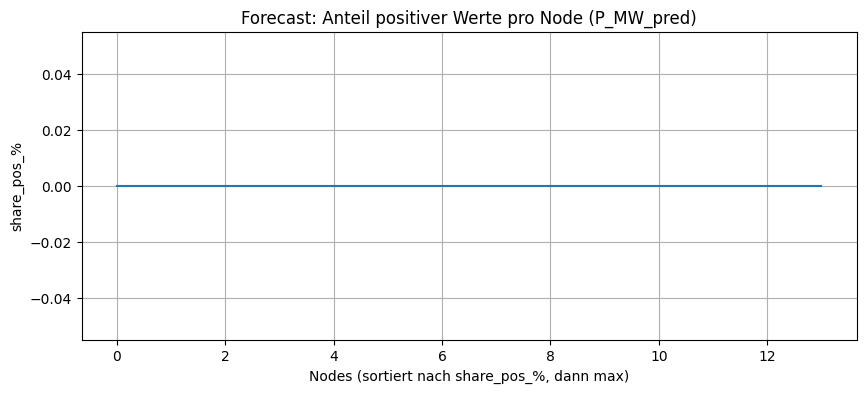

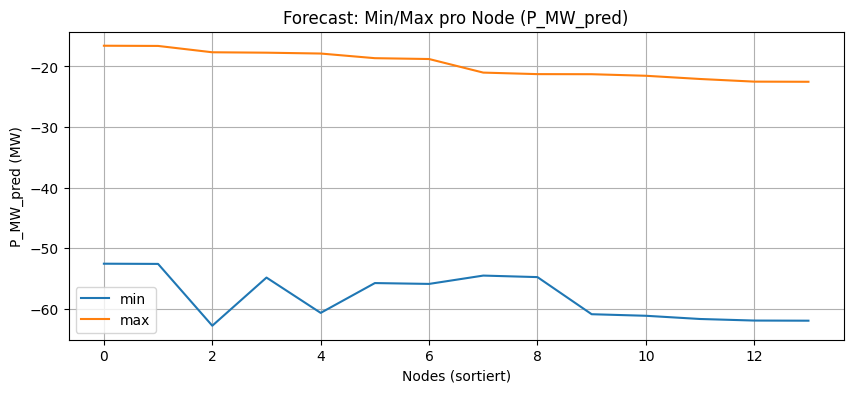


=== Timestamp-Level Summary ===
        sumP_MW  sumAbs_MW  share_pos_nodes_%  share_neg_nodes_%
count  100.0000   100.0000              100.0              100.0
mean  -627.1203   627.1203                0.0              100.0
std    141.4323   141.4323                0.0                0.0
min   -803.7928   276.0555                0.0              100.0
1%    -800.4610   298.4989                0.0              100.0
5%    -795.0641   330.6518                0.0              100.0
50%   -624.2324   624.2324                0.0              100.0
95%   -330.6518   795.0641                0.0              100.0
99%   -298.4989   800.4610                0.0              100.0
max   -276.0555   803.7928                0.0              100.0


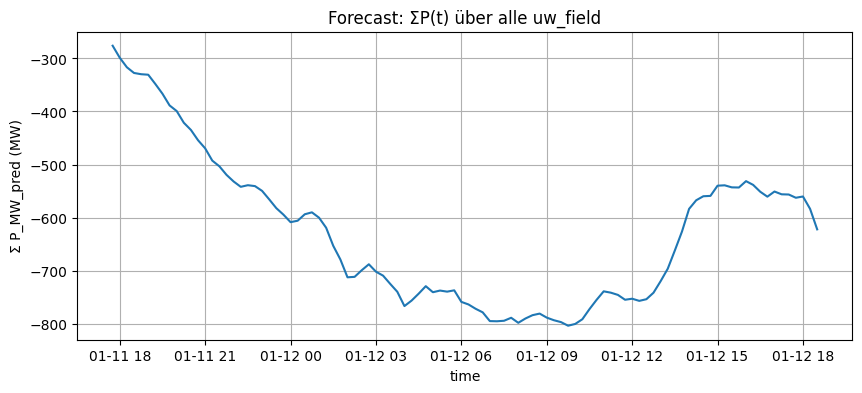

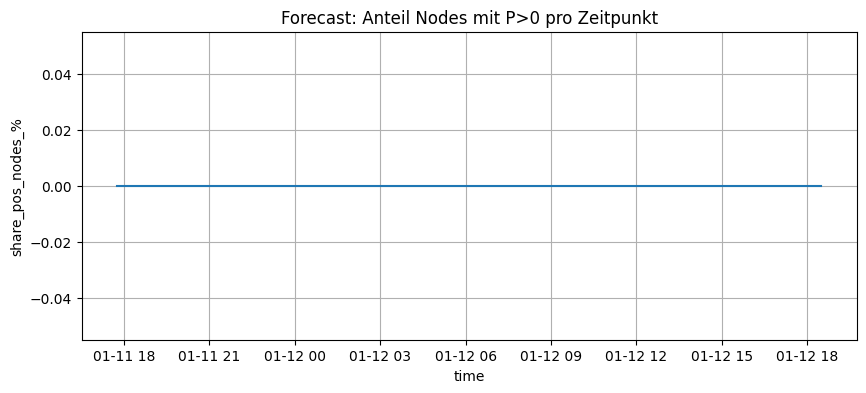


=== Extremzeitpunkte ===
min ΣP: 2026-01-12 09:45:00 -803.7928348640453
max ΣP: 2026-01-11 17:45:00 -276.0555202787274
max share_pos_nodes_%: 2026-01-11 17:45:00 0.0


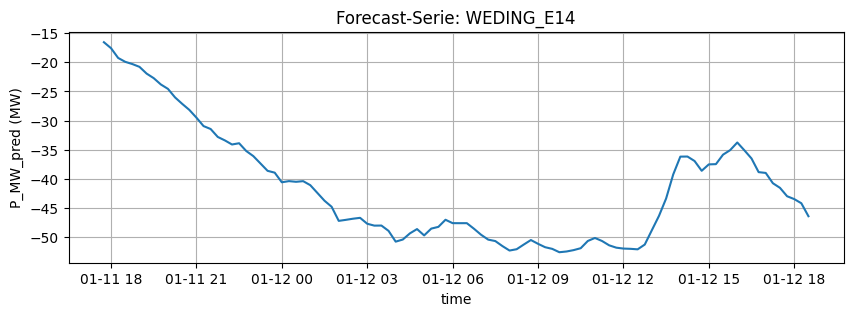

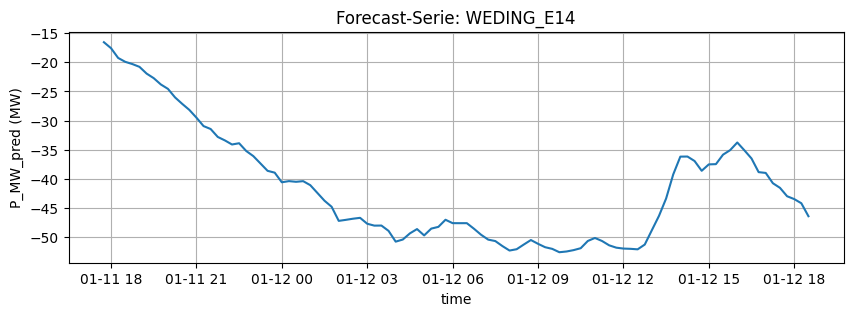


=== Interpretation-Hinweis ===
- Wenn bei allen Nodes max<=0 und share_pos_%≈0, ist die Prognose per Definition reine Last.
- Dann ist dein DC-Loadflow mit Injection-Konvention (P_inj=-P_MW_pred) zwangsläufig überall P_inj<=0.
- Konsequenz: Das Teilnetz braucht ein modelliertes 'Gegenstück' (Restnetz-Austausch / Einspeiser / Kuppelstelle), sonst drückt der Slack alles durch interne Leitungen.


In [13]:
# =============================================================================
# EDA: Forecast-Vorzeichen / Verteilungen / Ausreißer / Plausibilität
# Voraussetzung:
# - PRED_DIR zeigt auf Ordner mit "<NODE>_pred.csv"
# - CSV-Spalten: TS_COL="timestamp", PRED_COL="P_MW_pred"
# - FORECAST_NODE_TYPES={"uw_field"} und node_types/nodes sind aus deinem Graph geladen
# =============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# ---------------------------
# Config (falls noch nicht gesetzt)
# ---------------------------
PRED_DIR  = Path("src/data/pred")
TS_COL    = "timestamp"
PRED_COL  = "P_MW_pred"
SUFFIX    = "_pred.csv"

# Welche Nodes sollen geprüft werden?
# -> wenn du schon uw_fields hast: nutze die
try:
    uw_fields  # noqa
except NameError:
    # Fallback: alle Dateien im pred-dir -> node_id aus Dateiname
    uw_fields = sorted([p.name.replace(SUFFIX, "") for p in PRED_DIR.glob(f"*{SUFFIX}")])

# ---------------------------
# Loader
# ---------------------------
def read_pred_df(node_id: str) -> pd.DataFrame:
    path = PRED_DIR / f"{node_id}{SUFFIX}"
    if not path.is_file():
        return None
    df = pd.read_csv(path)
    if TS_COL not in df.columns or PRED_COL not in df.columns:
        raise ValueError(f"{path}: erwartete Spalten {TS_COL},{PRED_COL} fehlen. Spalten: {list(df.columns)}")
    df = df[[TS_COL, PRED_COL]].copy()
    df[TS_COL] = pd.to_datetime(df[TS_COL], errors="coerce")
    df[PRED_COL] = pd.to_numeric(df[PRED_COL], errors="coerce")
    df = df.dropna(subset=[TS_COL]).sort_values(TS_COL)
    return df

# ---------------------------
# 1) Node-Level Summary
# ---------------------------
rows = []
bad_files = []
for nid in uw_fields:
    df = read_pred_df(nid)
    if df is None or df.empty:
        bad_files.append(nid)
        continue
    s = df[PRED_COL].dropna()
    if s.empty:
        bad_files.append(nid)
        continue

    eps = 1e-6
    rows.append({
        "node": nid,
        "n": int(s.shape[0]),
        "min": float(s.min()),
        "p01": float(s.quantile(0.01)),
        "p05": float(s.quantile(0.05)),
        "median": float(s.median()),
        "p95": float(s.quantile(0.95)),
        "p99": float(s.quantile(0.99)),
        "max": float(s.max()),
        "mean": float(s.mean()),
        "std": float(s.std(ddof=1)) if s.shape[0] > 1 else 0.0,
        "share_neg_%": float((s < -eps).mean() * 100.0),
        "share_zero_%": float((s.abs() <= eps).mean() * 100.0),
        "share_pos_%": float((s > eps).mean() * 100.0),
        "has_any_pos": bool((s > eps).any()),
        "has_any_neg": bool((s < -eps).any()),
    })

summary = pd.DataFrame(rows).set_index("node").sort_values(["share_pos_%", "max"], ascending=[False, False])

print("=== Forecast EDA: Node Summary (Top 20 nach share_pos_%) ===")
print(summary.head(20).round(4).to_string())

if bad_files:
    print("\n[WARN] Fehlende/leer/invalid:", bad_files[:20], "..." if len(bad_files) > 20 else "")

print("\n=== Aggregiert über alle Nodes (P_MW_pred, original) ===")
if not summary.empty:
    print("Nodes:", summary.shape[0], "| median share_pos_%:", float(summary["share_pos_%"].median()))
    print("Min über Nodes:", float(summary["min"].min()), "| Max über Nodes:", float(summary["max"].max()))
    print("Nodes mit irgend Positiv:", int(summary["has_any_pos"].sum()), "/", summary.shape[0])

# ---------------------------
# 2) Quick Plots: share_pos_% pro Node + min/max ranges
# ---------------------------
if not summary.empty:
    # (a) Anteil positiver Werte pro Node
    plt.figure(figsize=(10, 4))
    plt.plot(summary["share_pos_%"].values)
    plt.xlabel("Nodes (sortiert nach share_pos_%, dann max)")
    plt.ylabel("share_pos_%")
    plt.title("Forecast: Anteil positiver Werte pro Node (P_MW_pred)")
    plt.grid(True)
    plt.show()

    # (b) Min/Max Band pro Node (zeigt ob alles <0 ist)
    plt.figure(figsize=(10, 4))
    plt.plot(summary["min"].values, label="min")
    plt.plot(summary["max"].values, label="max")
    plt.xlabel("Nodes (sortiert)")
    plt.ylabel("P_MW_pred (MW)")
    plt.title("Forecast: Min/Max pro Node (P_MW_pred)")
    plt.grid(True)
    plt.legend()
    plt.show()

# ---------------------------
# 3) Timestamp-Level: Wie sieht die Gesamtsumme aus?
#    -> Prüft, ob die Prognose insgesamt immer nur Last ist.
# ---------------------------
# Wir bauen eine gemeinsame Zeitachse über alle Nodes (outer join),
# und schauen:
# - ΣP(t) (original)
# - Σ|P|(t)
# - Anteil positiver Nodes pro t
dfs = []
for nid in uw_fields:
    df = read_pred_df(nid)
    if df is None or df.empty:
        continue
    tmp = df.set_index(TS_COL)[[PRED_COL]].rename(columns={PRED_COL: nid})
    dfs.append(tmp)

if dfs:
    M = pd.concat(dfs, axis=1).sort_index()
    # fehlende -> 0 (wenn Forecast nicht vorhanden)
    M = M.fillna(0.0)

    sumP = M.sum(axis=1)
    sumAbs = M.abs().sum(axis=1)
    share_pos_nodes = (M > 1e-6).mean(axis=1) * 100.0
    share_neg_nodes = (M < -1e-6).mean(axis=1) * 100.0

    ts_df = pd.DataFrame({
        "sumP_MW": sumP,
        "sumAbs_MW": sumAbs,
        "share_pos_nodes_%": share_pos_nodes,
        "share_neg_nodes_%": share_neg_nodes,
    })

    print("\n=== Timestamp-Level Summary ===")
    print(ts_df.describe(percentiles=[0.01,0.05,0.5,0.95,0.99]).round(4).to_string())

    # Plot: sumP und share_pos_nodes
    plt.figure(figsize=(10, 4))
    plt.plot(ts_df.index, ts_df["sumP_MW"].values)
    plt.xlabel("time")
    plt.ylabel("Σ P_MW_pred (MW)")
    plt.title("Forecast: ΣP(t) über alle uw_field")
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 4))
    plt.plot(ts_df.index, ts_df["share_pos_nodes_%"].values)
    plt.xlabel("time")
    plt.ylabel("share_pos_nodes_%")
    plt.title("Forecast: Anteil Nodes mit P>0 pro Zeitpunkt")
    plt.grid(True)
    plt.show()

    # Extremzeitpunkte
    print("\n=== Extremzeitpunkte ===")
    print("min ΣP:", ts_df["sumP_MW"].idxmin(), float(ts_df["sumP_MW"].min()))
    print("max ΣP:", ts_df["sumP_MW"].idxmax(), float(ts_df["sumP_MW"].max()))
    print("max share_pos_nodes_%:", ts_df["share_pos_nodes_%"].idxmax(), float(ts_df["share_pos_nodes_%"].max()))

else:
    print("\n[WARN] Konnte keine Forecast-DFs laden für Timestamp-Level Analyse.")

# ---------------------------
# 4) Drilldown: Beispiel-Node(s) visualisieren
# ---------------------------
# Wähle automatisch 2 Nodes:
# - den mit größtem max (falls der <=0 ist -> "immer negativ")
# - den mit größter share_pos_% (falls >0)
if not summary.empty:
    cand1 = summary.sort_values("max", ascending=False).index[0]
    cand2 = summary.sort_values("share_pos_%", ascending=False).index[0]

    for nid in [cand1, cand2]:
        df = read_pred_df(nid)
        if df is None or df.empty:
            continue
        plt.figure(figsize=(10, 3))
        plt.plot(df[TS_COL], df[PRED_COL])
        plt.xlabel("time")
        plt.ylabel("P_MW_pred (MW)")
        plt.title(f"Forecast-Serie: {nid}")
        plt.grid(True)
        plt.show()

print("\n=== Interpretation-Hinweis ===")
print("- Wenn bei allen Nodes max<=0 und share_pos_%≈0, ist die Prognose per Definition reine Last.")
print("- Dann ist dein DC-Loadflow mit Injection-Konvention (P_inj=-P_MW_pred) zwangsläufig überall P_inj<=0.")
print("- Konsequenz: Das Teilnetz braucht ein modelliertes 'Gegenstück' (Restnetz-Austausch / Einspeiser / Kuppelstelle), sonst drückt der Slack alles durch interne Leitungen.")


In [14]:
# === STEP 1: Sign-Check "clean history" vs "forecast" (pro Node) ===
import pandas as pd
import numpy as np
from pathlib import Path

CLEAN_DIR = Path("src/data/clean/timeseries_no_bess")
PRED_DIR  = Path("src/data/pred")

TS_COL = "timestamp"
HIST_COL = "P_MW"         # so wie in forecast.py meta.target_col default
PRED_COL = "P_MW_pred"

# nimm ein paar Nodes (oder alle). Erstmal wenige = schneller/übersichtlicher.
nodes = sorted([p.stem.replace("_hist_clean", "") for p in CLEAN_DIR.glob("*_hist_clean.csv")])[:10]

rows = []
for node in nodes:
    hist_path = CLEAN_DIR / f"{node}_hist_clean.csv"
    pred_path = PRED_DIR  / f"{node}_pred.csv"

    # history
    h = pd.read_csv(hist_path)
    h[TS_COL] = pd.to_datetime(h[TS_COL], errors="coerce")
    h = h.dropna(subset=[TS_COL])
    if HIST_COL not in h.columns:
        raise ValueError(f"{hist_path} missing {HIST_COL}")
    y = pd.to_numeric(h[HIST_COL], errors="coerce").dropna()

    # forecast (optional)
    if pred_path.exists():
        f = pd.read_csv(pred_path)
        f[TS_COL] = pd.to_datetime(f[TS_COL], errors="coerce")
        f = f.dropna(subset=[TS_COL])
        if PRED_COL not in f.columns:
            raise ValueError(f"{pred_path} missing {PRED_COL}")
        yp = pd.to_numeric(f[PRED_COL], errors="coerce").dropna()
    else:
        yp = pd.Series(dtype=float)

    def share_pos_neg_zero(s: pd.Series):
        if len(s) == 0:
            return (np.nan, np.nan, np.nan)
        s = s.astype(float)
        pos = (s >  1e-9).mean() * 100
        neg = (s < -1e-9).mean() * 100
        zer = (abs(s) <= 1e-9).mean() * 100
        return (pos, neg, zer)

    h_pos, h_neg, h_zero = share_pos_neg_zero(y)
    p_pos, p_neg, p_zero = share_pos_neg_zero(yp)

    rows.append({
        "node": node,
        "hist_n": int(y.shape[0]),
        "hist_min": float(y.min()) if len(y) else np.nan,
        "hist_median": float(y.median()) if len(y) else np.nan,
        "hist_max": float(y.max()) if len(y) else np.nan,
        "hist_share_pos_%": h_pos,
        "hist_share_neg_%": h_neg,

        "pred_n": int(yp.shape[0]),
        "pred_min": float(yp.min()) if len(yp) else np.nan,
        "pred_median": float(yp.median()) if len(yp) else np.nan,
        "pred_max": float(yp.max()) if len(yp) else np.nan,
        "pred_share_pos_%": p_pos,
        "pred_share_neg_%": p_neg,
    })

df = pd.DataFrame(rows).sort_values("pred_share_pos_%", ascending=False)

pd.set_option("display.max_columns", 999)
print(df.to_string(index=False))

# Zusätzlich: ein Node detailliert anzeigen (erste Zeile)
if len(df):
    node0 = df.iloc[0]["node"]
    print("\n=== DETAIL (letzte 20 HIST / erste 20 PRED) für:", node0, "===\n")
    h0 = pd.read_csv(CLEAN_DIR / f"{node0}_hist_clean.csv")
    h0[TS_COL] = pd.to_datetime(h0[TS_COL], errors="coerce")
    h0 = h0.dropna(subset=[TS_COL]).sort_values(TS_COL)
    print("HIST tail:\n", h0[[TS_COL, HIST_COL]].tail(20).to_string(index=False))

    p0p = PRED_DIR / f"{node0}_pred.csv"
    if p0p.exists():
        p0 = pd.read_csv(p0p)
        p0[TS_COL] = pd.to_datetime(p0[TS_COL], errors="coerce")
        p0 = p0.dropna(subset=[TS_COL]).sort_values(TS_COL)
        print("\nPRED head:\n", p0[[TS_COL, PRED_COL]].head(20).to_string(index=False))
    else:
        print("\n(no pred file for this node)")


    node  hist_n    hist_min  hist_median   hist_max  hist_share_pos_%  hist_share_neg_%  pred_n   pred_min  pred_median   pred_max  pred_share_pos_%  pred_share_neg_%
BOLN_E01   68859  -20.360947    -2.739404   0.256795         18.784763         80.537039     100 -55.740827   -42.990364 -18.634944               0.0             100.0
BOLN_E02   68860   -1.289830    10.341260  63.098640         86.376706         13.190532     100 -54.833491   -42.083028 -17.727608               0.0             100.0
BOLN_E03   68845  -43.784824    -6.946775   1.131041         16.002615         83.448326     100 -55.880313   -43.129849 -18.774429               0.0             100.0
JUBO_E01   71207  -61.828244    14.372850  85.655653         94.104512          5.267741     100 -61.137838   -46.358423 -21.537688               0.0             100.0
JUBO_E02   69062  -58.242793    -8.688288   7.473509         13.421274         86.578726     100 -61.667935   -46.888520 -22.067785               0.0           

In [15]:
# === STEP: Forecast auf Teilnetz bilanzieren (Slack explizit) ===
# Voraussetzung: P_df_super (Zeit x Supernodes), Injection-Konvention:
#   Einspeisung + , Last -

SLACK_NODE = "SHUW"   # dein definierter Slack

P_bal = P_df.copy()

rows = []
for t in P_bal.index:
    P_row = P_bal.loc[t]

    mismatch = P_row.sum()   # ΣP_inj
    # Externes Netz gleicht aus → Slack übernimmt
    P_bal.loc[t, SLACK_NODE] = P_row.get(SLACK_NODE, 0.0) - mismatch

    rows.append({
        "t": t,
        "sum_P_before": float(P_row.sum()),
        "P_slack_added": float(-mismatch),
        "sum_P_after": float(P_bal.loc[t].sum()),
    })

dbg = pd.DataFrame(rows).set_index("t")

print("=== Bilanz-Check ===")
print(dbg.head().round(3))
print("\nmax |sum_P_after|:", dbg["sum_P_after"].abs().max())


=== Bilanz-Check ===
                     sum_P_before  P_slack_added  sum_P_after
t                                                            
2024-01-01 00:00:00          -0.0        -11.370         -0.0
2024-01-01 00:15:00           0.0        -11.932          0.0
2024-01-01 00:30:00           0.0         -9.190          0.0
2024-01-01 00:45:00           0.0         -9.225          0.0
2024-01-01 01:00:00           0.0        -11.471          0.0

max |sum_P_after|: 6.750155989720952e-14


# super important cell

In [16]:
# --- Forecast Normalization: flip-check + level-align + quantile-clip ---
import pandas as pd
import numpy as np
from pathlib import Path

HIST_DIR = Path("src/data/clean/timeseries_no_bess")
PRED_DIR = Path("src/data/pred")
OUT_DIR  = Path("src/data/pred_normalized")
OUT_DIR.mkdir(parents=True, exist_ok=True)

TS_COL = "timestamp"
HIST_COL = "P_MW"
PRED_COL = "P_MW_pred"

# Wie stark clippen? (an Historie orientiert)
CLIP_Q_LO = 0.01
CLIP_Q_HI = 0.99

# Wie viele erste Schritte zur Plausibilitätsprüfung?
K_CHECK = 8

def load_hist(node_id: str) -> pd.Series:
    p = HIST_DIR / f"{node_id}_hist_clean.csv"
    df = pd.read_csv(p)
    df[TS_COL] = pd.to_datetime(df[TS_COL], utc=False)
    s = pd.to_numeric(df[HIST_COL], errors="coerce").dropna()
    s.index = df.loc[s.index, TS_COL]
    return s.sort_index()

def load_pred(node_id: str) -> pd.Series:
    p = PRED_DIR / f"{node_id}_pred.csv"
    df = pd.read_csv(p)
    df[TS_COL] = pd.to_datetime(df[TS_COL], utc=False)
    s = pd.to_numeric(df[PRED_COL], errors="coerce").fillna(0.0)
    s.index = df[TS_COL]
    return s.sort_index()

def score_candidate(pred: pd.Series, hist: pd.Series) -> float:
    """
    Kleiner = besser.
    Heuristik: (1) Nähe zum letzten Hist-Level in den ersten K Steps,
               (2) „typische“ Größenordnung vs. Hist-IQR
    """
    last = float(hist.iloc[-1])
    k = min(K_CHECK, len(pred))
    head = pred.iloc[:k].to_numpy()

    # (1) Level-Nähe
    level_err = np.mean(np.abs(head - last))

    # (2) Größenordnung: Distanz zur Hist-Verteilung (robust über IQR)
    q25, q75 = np.quantile(hist.to_numpy(), [0.25, 0.75])
    iqr = max(q75 - q25, 1e-6)
    z = np.mean(np.abs((head - np.median(hist)) / iqr))

    return float(level_err + 0.3 * z)

def normalize_pred(node_id: str) -> pd.DataFrame:
    hist = load_hist(node_id)
    pred = load_pred(node_id)

    # Kandidat A: wie er ist
    pred_a = pred.copy()

    # Kandidat B: Vorzeichen flip
    pred_b = -pred.copy()

    # Wähle plausibleren Kandidaten
    sa = score_candidate(pred_a, hist)
    sb = score_candidate(pred_b, hist)
    use_flip = sb < sa
    pred_use = pred_b if use_flip else pred_a

    # Level-Alignment: ersten Forecast-Step an letztes Hist-Level andocken
    last_hist = float(hist.iloc[-1])
    first_pred = float(pred_use.iloc[0])
    shift = last_hist - first_pred
    pred_aligned = pred_use + shift

    # Clip auf Hist-Quantile (optional, aber hilft gegen Eskalation)
    lo = float(np.quantile(hist.to_numpy(), CLIP_Q_LO))
    hi = float(np.quantile(hist.to_numpy(), CLIP_Q_HI))
    pred_clipped = pred_aligned.clip(lower=lo, upper=hi)

    out = pd.DataFrame({
        TS_COL: pred.index.astype(str),
        "P_MW_pred_raw": pred.values,
        "used_flip": int(use_flip),
        "shift_added_MW": shift,
        "hist_q01": lo,
        "hist_q99": hi,
        "P_MW_pred_norm": pred_clipped.values,
    })

    # Speichern: gleiche Dateinamen, aber in OUT_DIR
    out_path = OUT_DIR / f"{node_id}_pred.csv"
    out.to_csv(out_path, index=False)

    return out

# --- Run: alle pred files ---
pred_files = sorted(PRED_DIR.glob("*_pred.csv"))
node_ids = [p.stem.replace("_pred", "") for p in pred_files]

rows = []
for nid in node_ids:
    try:
        df_out = normalize_pred(nid)
        rows.append({
            "node_id": nid,
            "ok": True,
            "used_flip": int(df_out["used_flip"].iloc[0]),
            "shift_added_MW": float(df_out["shift_added_MW"].iloc[0]),
            "pred_min_norm": float(df_out["P_MW_pred_norm"].min()),
            "pred_max_norm": float(df_out["P_MW_pred_norm"].max()),
        })
    except Exception as e:
        rows.append({"node_id": nid, "ok": False, "error": str(e)})

summary = pd.DataFrame(rows).sort_values(["ok","node_id"], ascending=[False, True])
print("=== Normalization Summary ===")
print(summary.to_string(index=False))

print("\nOUT_DIR:", OUT_DIR)
print("Nächster Schritt: In deinem Loadflow-Code PRED_DIR auf OUT_DIR umstellen und nochmal util_% prüfen.")


=== Normalization Summary ===
   node_id   ok  used_flip  shift_added_MW  pred_min_norm  pred_max_norm
  BOLN_E01 True          0       16.173948     -19.717760      -2.460996
  BOLN_E02 True          1      -11.251298       6.476310      43.582194
  BOLN_E03 True          0       14.759115     -39.821251      -4.015314
  JUBO_E01 True          1      -21.537688       0.000000      39.600150
  JUBO_E02 True          0       12.773026     -48.894909      -9.294759
  JUBO_E03 True          0       19.654594     -28.452186      -1.626247
  SHUW_E23 True          0       12.132029     -42.373910      -8.882301
  SHUW_E24 True          0        8.429299     -46.327441     -12.835832
  SIES_E02 True          0       16.467621     -12.237320      -1.400272
  SIEV_E01 True          0       13.642488     -49.136444      -4.017407
  TARP_E01 True          1      -17.620245       4.884110      44.306001
  TARP_E03 True          1      -21.381962       1.145302      40.567194
WEDING_E12 True      

In [20]:
import pandas as pd
from pathlib import Path

NODE = "BOLN_E01"  # nimm gern 2-3 kritische nodes durch

# Pfade
HIST_PATH = Path("src/data/clean/timeseries_no_bess") / f"{NODE}_hist_clean.csv"
PRED_PATH = Path("src/data/pred_normalized") / f"{NODE}_pred.csv"  # ggf. _pred_norm.csv etc.

TS_COL = "timestamp"
HIST_COL = "P_MW"
PRED_COL = "P_MW_pred_norm"   # dein norm-col

# Load
hist = pd.read_csv(HIST_PATH)
pred = pd.read_csv(PRED_PATH)

hist[TS_COL] = pd.to_datetime(hist[TS_COL])
pred[TS_COL] = pd.to_datetime(pred[TS_COL])

hist = hist.sort_values(TS_COL)
pred = pred.sort_values(TS_COL)

# Align window: letzte 2h hist + ganze pred
t0 = pred[TS_COL].min()
hist_win = hist[hist[TS_COL] >= (t0 - pd.Timedelta(hours=2))].copy()

print("=== Window ===")
print("hist:", hist_win[TS_COL].min(), "->", hist_win[TS_COL].max(), "n=", len(hist_win))
print("pred:", pred[TS_COL].min(), "->", pred[TS_COL].max(), "n=", len(pred))

print("\n=== Tail hist (last 10) ===")
print(hist_win[[TS_COL, HIST_COL]].tail(10).to_string(index=False))

print("\n=== Head pred (first 10) ===")
print(pred[[TS_COL, PRED_COL]].head(10).to_string(index=False))

# Quick sanity: Sprung am Übergang
last_hist = float(hist[HIST_COL].iloc[-1])
first_pred = float(pred[PRED_COL].iloc[0])

print("\n=== Transition check ===")
print("last_hist:", last_hist)
print("first_pred:", first_pred)
print("delta:", first_pred - last_hist)


=== Window ===
hist: 2026-01-11 15:45:00 -> 2026-01-11 17:30:00 n= 8
pred: 2026-01-11 17:45:00 -> 2026-01-12 18:30:00 n= 100

=== Tail hist (last 10) ===
          timestamp      P_MW
2026-01-11 15:45:00 -0.389038
2026-01-11 16:00:00 -0.364566
2026-01-11 16:15:00 -0.579369
2026-01-11 16:30:00 -0.643959
2026-01-11 16:45:00 -0.735972
2026-01-11 17:00:00 -1.170156
2026-01-11 17:15:00 -1.626691
2026-01-11 17:30:00 -2.460996

=== Head pred (first 10) ===
          timestamp  P_MW_pred_norm
2026-01-11 17:45:00       -2.460996
2026-01-11 18:00:00       -4.671461
2026-01-11 18:15:00       -6.044797
2026-01-11 18:30:00       -5.521124
2026-01-11 18:45:00       -5.902963
2026-01-11 19:00:00       -5.488117
2026-01-11 19:15:00       -7.235549
2026-01-11 19:30:00       -8.085433
2026-01-11 19:45:00      -10.353917
2026-01-11 20:00:00      -10.876968

=== Transition check ===
last_hist: -2.460996
first_pred: -2.4609960000000015
delta: -1.3322676295501878e-15


In [22]:
import pandas as pd
from pathlib import Path
import numpy as np

HIST_DIR = Path("src/data/clean/timeseries_no_bess")
PRED_DIR = Path("src/data/pred_normalized")

TS_COL = "timestamp"
HIST_COL = "P_MW"
PRED_COL = "P_MW_pred_norm"

rows = []

for hist_path in sorted(HIST_DIR.glob("*_hist_clean.csv")):
    node = hist_path.stem.replace("_hist_clean", "")
    pred_path = PRED_DIR / f"{node}_pred.csv"
    if not pred_path.exists():
        continue

    hist = pd.read_csv(hist_path)
    pred = pd.read_csv(pred_path)

    if TS_COL not in hist.columns or HIST_COL not in hist.columns:
        continue
    if TS_COL not in pred.columns or PRED_COL not in pred.columns:
        continue

    hist[TS_COL] = pd.to_datetime(hist[TS_COL], errors="coerce")
    pred[TS_COL] = pd.to_datetime(pred[TS_COL], errors="coerce")
    hist = hist.sort_values(TS_COL).dropna(subset=[TS_COL, HIST_COL])
    pred = pred.sort_values(TS_COL).dropna(subset=[TS_COL, PRED_COL])

    if hist.empty or pred.empty:
        continue

    last_hist = float(hist[HIST_COL].iloc[-1])
    first_pred = float(pred[PRED_COL].iloc[0])
    jump = first_pred - last_hist

    # typische Größenordnung (Median |P| der letzten 7 Tage)
    t_end = hist[TS_COL].iloc[-1]
    hist_7d = hist[hist[TS_COL] >= (t_end - pd.Timedelta(days=7))]
    scale = float(hist_7d[HIST_COL].abs().median()) if len(hist_7d) else float(hist[HIST_COL].abs().median())
    scale = max(scale, 1e-6)

    rows.append({
        "node": node,
        "last_hist": last_hist,
        "first_pred": first_pred,
        "jump": jump,
        "jump_rel_to_median_abs_7d": jump / scale,
        "hist_abs_median_7d": scale,
        "pred_min": float(pred[PRED_COL].min()),
        "pred_median": float(pred[PRED_COL].median()),
        "pred_max": float(pred[PRED_COL].max()),
    })

df = pd.DataFrame(rows)

if df.empty:
    print("Keine passenden Node-Paare gefunden (hist_clean + pred_normalized).")
else:
    df["jump_abs"] = df["jump"].abs()

    print("Nodes checked:", len(df))

    print("\nTop 10 nach |jump|:")
    print(df.sort_values("jump_abs", ascending=False).head(10).round(6).to_string(index=False))

    print("\nSummary |jump|:")
    print(df["jump_abs"].describe().round(6).to_string())

    # Optional: wie viele sind "quasi perfekt" angenäht?
    eps = 1e-6
    share_ok = (df["jump_abs"] <= eps).mean() * 100
    print(f"\nShare mit |jump| <= {eps}: {share_ok:.1f}%")


Nodes checked: 14

Top 10 nach |jump|:
    node  last_hist  first_pred  jump  jump_rel_to_median_abs_7d  hist_abs_median_7d   pred_min  pred_median  pred_max  jump_abs
TARP_E01   4.884110    4.884110  -0.0                       -0.0           10.642273   4.884110    30.011306 44.306001       0.0
SIES_E02  -1.400272   -1.400272  -0.0                       -0.0            3.584798 -12.237320   -12.237320 -1.400272       0.0
TARP_E03   1.145302    1.145302   0.0                        0.0            6.797829   1.145302    26.272499 40.567194       0.0
BOLN_E01  -2.460996   -2.460996  -0.0                       -0.0            4.166063 -19.717760   -19.717760 -2.460996       0.0
JUBO_E03  -1.626247   -1.626247   0.0                        0.0            2.007169 -28.452186   -26.446982 -1.626247       0.0
BOLN_E02   6.476310    6.476310   0.0                        0.0           14.290854   6.476310    30.831730 43.582194       0.0
BOLN_E03  -4.015314   -4.015314   0.0                     

In [24]:
# ==========================
# BUILD util_df over time
# Voraussetzung: Alles bis inkl. comp_data / PTDF_by_comp / edge_meta ist bereits gelaufen.
# ==========================

# 1) Zeitfenster wählen
if len(P_df) == 0:
    raise RuntimeError("P_df ist leer – keine Zeitstempel in Forecasts?")

if T_TARGET is None:
    t_start = P_df.index[0]
else:
    t_start = pd.to_datetime(T_TARGET)
    if t_start not in P_df.index:
        t_start = P_df.index[P_df.index.get_indexer([t_start], method="nearest")[0]]

start_loc = P_df.index.get_loc(t_start)
sel_index = P_df.index[start_loc : start_loc + N_TIMESTEPS]

print("t_start:", t_start)
print("N_TIMESTEPS (sel_index):", len(sel_index))

# 2) Helper: ein Timestamp -> line_df (mit util_%)
def compute_line_df_for_timestamp(t):
    P_row = P_df.loc[t].copy()

    theta_global = np.zeros(len(super_nodes), dtype=float)
    flows_now = {}

    # optional mismatch log
    mm_rows = []

    for comp in components:
        ck = frozenset(comp)
        info = comp_data[ck]
        slack = info["slack"]
        non_slack = info["non_slack_nodes"]
        non_slack_idx = info["non_slack_idx"]
        B_rr = info["B_rr"]

        # Bilanz check & Slack-Korrektur
        P_comp = np.array([P_row[n] for n in comp], dtype=float)
        mismatch = float(P_comp.sum())

        if LOG_MISMATCH:
            mm_rows.append({"t": t, "component_size": len(comp), "slack": slack, "mismatch_MW": mismatch})

        # Slack gleicht mismatch aus
        if abs(mismatch) > 1e-9:
            P_row[slack] = P_row.get(slack, 0.0) - mismatch

        if len(non_slack) == 0:
            continue

        P_ns_MW = np.array([P_row[n] for n in non_slack], dtype=float)
        P_ns_pu = P_ns_MW / S_BASE_MVA

        # solve statt inv
        theta_ns = np.linalg.solve(B_rr, P_ns_pu)

        for local_i, idx_g in enumerate(non_slack_idx):
            theta_global[idx_g] = theta_ns[local_i]

        # Flüsse auf Leitungen dieser Komponente
        comp_lines = PTDF_by_comp[ck]["lines"]
        for (u, v, Xpu, eid, feat) in comp_lines:
            i, j = node_index[u], node_index[v]
            f_pu = (theta_global[i] - theta_global[j]) / Xpu
            flows_now[eid] = f_pu * S_BASE_MVA

    # line df bauen
    line_rows = []
    for eid, fMW in flows_now.items():
        meta = edge_meta[eid]
        I_A = mw_to_amp_with_pf(fMW, meta["VkV"], COSPHI_MIN)

        limA = meta["limit_A"]
        util = np.nan
        if limA not in (None, ""):
            try:
                limA = float(limA)
                if limA > 0:
                    util = abs(I_A) / limA * 100.0
            except:
                limA = np.nan

        line_rows.append({
            "timestamp": t,
            "edge_id": eid,
            "u_rep": meta["u"],
            "v_rep": meta["v"],
            "P_MW": fMW,
            "I_A": I_A,
            "limit_A": limA,
            "util_%": util,
        })

    line_df = pd.DataFrame(line_rows)
    line_df = line_df.sort_values("util_%", ascending=False)

    mm_df = pd.DataFrame(mm_rows) if (LOG_MISMATCH and mm_rows) else None
    return line_df, mm_df


# 3) Loop über alle Zeitpunkte -> util_df
UTIL_DFS = []
MM_DFS = []

for t in sel_index:  # <<< nicht mehr [:1]
    df_lines, df_mm = compute_line_df_for_timestamp(t)
    UTIL_DFS.append(df_lines)
    if df_mm is not None:
        MM_DFS.append(df_mm)

util_df = pd.concat(UTIL_DFS, ignore_index=True) if UTIL_DFS else pd.DataFrame()

print("\nutil_df gebaut:")
print(util_df.head(10).round(3).to_string(index=False))
print("Rows:", len(util_df), "| unique timestamps:", util_df["timestamp"].nunique() if not util_df.empty else 0)

# optional mismatch df
if MM_DFS:
    mismatch_df = pd.concat(MM_DFS, ignore_index=True)
    print("\nMismatch Summary (first 10 rows):")
    print(mismatch_df.head(10).round(6).to_string(index=False))

# 4) Mini-Auswertung: Top max util_% pro Leitung über den Zeitraum
if not util_df.empty:
    max_util = util_df.groupby("edge_id")["util_%"].max().sort_values(ascending=False)
    print("\nTop 10 max util_% über sel_index:")
    print(max_util.head(10).round(2).to_string())


t_start: 2026-01-11 17:45:00
N_TIMESTEPS (sel_index): 1

util_df gebaut:
          timestamp                                          edge_id      u_rep      v_rep   P_MW    I_A  limit_A  util_%
2026-01-11 17:45:00             110_SHUW_TARP_GELB_JUBO_JUBO_A5_JUBO       JUBO    JUBO_A5 10.921 60.337    632.0   9.547
2026-01-11 17:45:00                    110-TARP-WEDI-GRUEN TARP-WEDI   TARP_E01 WEDING_E14 -4.142 22.884    547.0   4.184
2026-01-11 17:45:00    110-SHUW-WEDI-ROT,BOLN,SIES,SIEV SIEV A3-SIEV    SIEV_A3   SIEV_E01 -4.017 22.196    547.0   4.058
2026-01-11 17:45:00 110-SHUW-WEDI-ROT,BOLN,SIES,SIEV BOLN A3-SIES A3    SIES_A3    BOLN_A3  3.511 19.400    545.0   3.560
2026-01-11 17:45:00 110-SHUW-WEDI-ROT,BOLN,SIES,SIEV BOLS A3-BOLN A3    BOLS_A3    BOLN_A3 -3.511 19.400    547.0   3.547
2026-01-11 17:45:00    110-SHUW-WEDI-ROT,BOLN,SIES,SIEV SHUW-BOLN A3       SHUW    BOLS_A3 -3.511 19.400    547.0   3.547
2026-01-11 17:45:00             110_SHUW_TARP_GELB_JUBO_SHUW_JUBO_A5    J

In [25]:
# STEP: Zeitraum auswerten und den schlimmsten Timestamp finden

N_TIMESTEPS = 100  # oder z.B. len(P_df) wenn du alles nehmen willst

# neu bauen
start_loc = P_df.index.get_loc(t_start)
sel_index = P_df.index[start_loc : start_loc + N_TIMESTEPS]

UTIL_DFS = []
MM_DFS = []

for t in sel_index:
    df_lines, df_mm = compute_line_df_for_timestamp(t)
    UTIL_DFS.append(df_lines)
    if df_mm is not None:
        MM_DFS.append(df_mm)

util_df = pd.concat(UTIL_DFS, ignore_index=True)

# 1) pro timestamp: maximale Auslastung
ts_max = util_df.groupby("timestamp")["util_%"].max().sort_values(ascending=False)
print("Top 10 Timestamps nach max util_%:")
print(ts_max.head(10).round(2).to_string())

# 2) worst timestamp nehmen und alle Leitungen dazu anzeigen
t_worst = ts_max.index[0]
print("\nWorst timestamp:", t_worst, "max util_%:", float(ts_max.iloc[0]))

worst_lines = util_df[util_df["timestamp"] == t_worst].sort_values("util_%", ascending=False)
print("\nTop 15 Leitungen @ worst timestamp:")
print(worst_lines.head(15).round(3).to_string(index=False))

# optional: mismatch dazu
if MM_DFS:
    mismatch_df = pd.concat(MM_DFS, ignore_index=True)
    mm_worst = mismatch_df[mismatch_df["t"] == t_worst]
    print("\nMismatch @ worst timestamp:")
    print(mm_worst.round(6).to_string(index=False))


Top 10 Timestamps nach max util_%:
timestamp
2026-01-12 08:00:00    74.17
2026-01-12 08:15:00    73.97
2026-01-12 10:00:00    73.59
2026-01-12 10:15:00    73.27
2026-01-12 07:45:00    73.18
2026-01-12 09:15:00    73.12
2026-01-12 07:30:00    73.04
2026-01-12 09:45:00    72.98
2026-01-12 09:30:00    72.95
2026-01-12 08:30:00    72.73

Worst timestamp: 2026-01-12 08:00:00 max util_%: 74.17352033852772

Top 15 Leitungen @ worst timestamp:
          timestamp                                          edge_id      u_rep      v_rep    P_MW     I_A  limit_A  util_%
2026-01-12 08:00:00                    110-TARP-WEDI-GRUEN TARP-WEDI   TARP_E01 WEDING_E14 -73.437 405.729    547.0  74.174
2026-01-12 08:00:00 110-SHUW-WEDI-ROT,BOLN,SIES,SIEV BOLS A3-BOLN A3    BOLS_A3    BOLN_A3 -60.270 332.985    547.0  60.875
2026-01-12 08:00:00    110-SHUW-WEDI-ROT,BOLN,SIES,SIEV SHUW-BOLN A3       SHUW    BOLS_A3 -60.270 332.985    547.0  60.875
2026-01-12 08:00:00    110-SHUW-WEDI-ROT,BOLN,SIES,SIEV SIEV A3-

In [27]:
# --- 1) Forecast-Run (über forecast.py) ---
import pandas as pd
from src.forecast import forecast_all_nodes

# überschreibt vorhandene Files (wie gewünscht)
summary = forecast_all_nodes(overwrite=True, max_hours_cap=None)

display(summary.head(20))
print("\nOK:", int((summary["ok"]==True).sum()), "| FAIL:", int((summary["ok"]==False).sum()))


,node_id,ok,pred_path,n_pred,error
0,BOLN_E01,True,/Users/martinkrawtzow/Documents/Masterthesis/t...,100,
1,BOLN_E02,True,/Users/martinkrawtzow/Documents/Masterthesis/t...,100,
2,BOLN_E03,True,/Users/martinkrawtzow/Documents/Masterthesis/t...,100,
3,JUBO_E01,True,/Users/martinkrawtzow/Documents/Masterthesis/t...,100,
4,JUBO_E02,True,/Users/martinkrawtzow/Documents/Masterthesis/t...,100,
5,JUBO_E03,True,/Users/martinkrawtzow/Documents/Masterthesis/t...,100,
6,SHUW_E23,True,/Users/martinkrawtzow/Documents/Masterthesis/t...,100,
7,SHUW_E24,True,/Users/martinkrawtzow/Documents/Masterthesis/t...,100,
8,SIES_E02,True,/Users/martinkrawtzow/Documents/Masterthesis/t...,100,
9,SIEV_E01,True,/Users/martinkrawtzow/Documents/Masterthesis/t...,100,



OK: 14 | FAIL: 0


In [28]:
# --- 2) Worst-Line / Worst-Timestamp über alle berechneten Timestamps ---
import pandas as pd

if "util_df" not in globals():
    raise RuntimeError("util_df is not defined. Bitte zuerst deine Lastfluss-Zelle laufen lassen, die util_df baut.")

# Sicherheitsfilter: nur Zeilen mit util_% (d.h. wo ein Limit vorhanden war)
u = util_df.copy()
u = u.dropna(subset=["util_%"])

# 1) pro timestamp: maximale Auslastung (die jeweils schlimmste Leitung)
per_t = u.groupby("timestamp")["util_%"].max().sort_values(ascending=False)

print("Top 10 Timestamps nach max util_%:")
print(per_t.head(10).to_string())

t_worst = per_t.index[0]
max_util = float(per_t.iloc[0])
print("\nWorst timestamp:", t_worst, "max util_%:", max_util)

# 2) welche Leitung war an diesem timestamp am schlimmsten?
worst_rows = u[u["timestamp"] == t_worst].sort_values("util_%", ascending=False)
worst_edge_id = worst_rows.iloc[0]["edge_id"]

print("\nTop 15 Leitungen @ worst timestamp:")
display(worst_rows.head(15))

print("\nWorst edge_id:", worst_edge_id)

# 3) globale Worst-Leitung über alle Zeitstempel: max util_% je edge_id
per_edge = u.groupby("edge_id")["util_%"].max().sort_values(ascending=False)

print("\nTop 10 Leitungen nach maximaler util_% über alle Zeitstempel:")
print(per_edge.head(10).to_string())

edge_worst = per_edge.index[0]
edge_worst_util = float(per_edge.iloc[0])
print("\nWorst edge overall:", edge_worst, "max util_%:", edge_worst_util)

# 4) wann trat das Maximum dieser Worst-Leitung auf?
edge_rows = u[u["edge_id"] == edge_worst].sort_values("util_%", ascending=False)
print("\nTop 10 Zeitpunkte für Worst edge overall:")
display(edge_rows[["timestamp","edge_id","u_rep","v_rep","P_MW","I_A","limit_A","util_%"]].head(10))


Top 10 Timestamps nach max util_%:
timestamp
2026-01-12 08:00:00    74.173520
2026-01-12 08:15:00    73.972053
2026-01-12 10:00:00    73.589077
2026-01-12 10:15:00    73.269471
2026-01-12 07:45:00    73.176889
2026-01-12 09:15:00    73.120063
2026-01-12 07:30:00    73.042426
2026-01-12 09:45:00    72.977804
2026-01-12 09:30:00    72.946636
2026-01-12 08:30:00    72.734500

Worst timestamp: 2026-01-12 08:00:00 max util_%: 74.17352033852772

Top 15 Leitungen @ worst timestamp:


,timestamp,edge_id,u_rep,v_rep,P_MW,I_A,limit_A,util_%
855,2026-01-12 08:00:00,110-TARP-WEDI-GRUEN TARP-WEDI,TARP_E01,WEDING_E14,-7.343670e+01,4.057292e+02,547.0,7.417352e+01
856,2026-01-12 08:00:00,"110-SHUW-WEDI-ROT,BOLN,SIES,SIEV BOLS A3-BOLN A3",BOLS_A3,BOLN_A3,-6.027005e+01,3.329850e+02,547.0,6.087477e+01
857,2026-01-12 08:00:00,"110-SHUW-WEDI-ROT,BOLN,SIES,SIEV SHUW-BOLN A3",SHUW,BOLS_A3,-6.027005e+01,3.329850e+02,547.0,6.087477e+01
858,2026-01-12 08:00:00,"110-SHUW-WEDI-ROT,BOLN,SIES,SIEV SIEV A3-SIEV",SIEV_A3,SIEV_E01,-4.749107e+01,2.623826e+02,547.0,4.796757e+01
859,2026-01-12 08:00:00,"110-SHUW-WEDI-ROT,BOLN,SIES,SIEV BOLN A3-SIES A3",SIES_A3,BOLN_A3,4.410238e+01,2.436605e+02,545.0,4.470835e+01
860,2026-01-12 08:00:00,110_SHUW_TARP_GELB_JUBO_JUBO_A5_JUBO,JUBO,JUBO_A5,3.774695e+01,2.085475e+02,632.0,3.299802e+01
861,2026-01-12 08:00:00,"110-SHUW-WEDI-ROT,BOLN,SIES,SIEV SIEV A3-SIES A3",SIES_A3,SIEV_A3,-3.186506e+01,1.760507e+02,555.0,3.172085e+01
862,2026-01-12 08:00:00,"110-SHUW-WEDI-ROT,BOLN,SIES,SIEV BOLN A3-BOLN",BOLN_A3,BOLN_E02,-1.616767e+01,8.932447e+01,547.0,1.632989e+01
863,2026-01-12 08:00:00,"110-SHUW-WEDI-ROT,BOLN,SIES,SIEV WEDI-SIEV A3",WEDING_E14,SIEV_A3,-1.562601e+01,8.633189e+01,547.0,1.578279e+01
864,2026-01-12 08:00:00,"110-SHUW-WEDI-ROT,BOLN,SIES,SIEV SIES A3-SIES",SIES_A3,SIES_E02,-1.223732e+01,6.760976e+01,547.0,1.236010e+01



Worst edge_id: 110-TARP-WEDI-GRUEN TARP-WEDI

Top 10 Leitungen nach maximaler util_% über alle Zeitstempel:
edge_id
110-TARP-WEDI-GRUEN TARP-WEDI                       74.173520
110-SHUW-WEDI-ROT,BOLN,SIES,SIEV BOLS A3-BOLN A3    64.196529
110-SHUW-WEDI-ROT,BOLN,SIES,SIEV SHUW-BOLN A3       64.196529
110-SHUW-WEDI-ROT,BOLN,SIES,SIEV SIEV A3-SIEV       49.629452
110-SHUW-WEDI-ROT,BOLN,SIES,SIEV BOLN A3-SIES A3    47.868159
110-SHUW-WEDI-ROT,BOLN,SIES,SIEV SIEV A3-SIES A3    34.823731
110_SHUW_TARP_GELB_JUBO_JUBO_A5_JUBO                32.998015
110-SHUW-WEDI-ROT,BOLN,SIES,SIEV BOLN A3-BOLN       17.429909
110-SHUW-WEDI-ROT,BOLN,SIES,SIEV WEDI-SIEV A3       16.291265
110_SHUW_TARP_GELB_JUBO_SHUW_JUBO_A5                14.650658

Worst edge overall: 110-TARP-WEDI-GRUEN TARP-WEDI max util_%: 74.17352033852772

Top 10 Zeitpunkte für Worst edge overall:


,timestamp,edge_id,u_rep,v_rep,P_MW,I_A,limit_A,util_%
855,2026-01-12 08:00:00,110-TARP-WEDI-GRUEN TARP-WEDI,TARP_E01,WEDING_E14,-73.436697,405.729156,547.0,74.173520
870,2026-01-12 08:15:00,110-TARP-WEDI-GRUEN TARP-WEDI,TARP_E01,WEDING_E14,-73.237231,404.627132,547.0,73.972053
975,2026-01-12 10:00:00,110-TARP-WEDI-GRUEN TARP-WEDI,TARP_E01,WEDING_E14,-72.858059,402.532248,547.0,73.589077
990,2026-01-12 10:15:00,110-TARP-WEDI-GRUEN TARP-WEDI,TARP_E01,WEDING_E14,-72.541628,400.784007,547.0,73.269471
840,2026-01-12 07:45:00,110-TARP-WEDI-GRUEN TARP-WEDI,TARP_E01,WEDING_E14,-72.449966,400.277581,547.0,73.176889
930,2026-01-12 09:15:00,110-TARP-WEDI-GRUEN TARP-WEDI,TARP_E01,WEDING_E14,-72.393705,399.966744,547.0,73.120063
825,2026-01-12 07:30:00,110-TARP-WEDI-GRUEN TARP-WEDI,TARP_E01,WEDING_E14,-72.316839,399.542073,547.0,73.042426
960,2026-01-12 09:45:00,110-TARP-WEDI-GRUEN TARP-WEDI,TARP_E01,WEDING_E14,-72.252859,399.188587,547.0,72.977804
945,2026-01-12 09:30:00,110-TARP-WEDI-GRUEN TARP-WEDI,TARP_E01,WEDING_E14,-72.222001,399.018100,547.0,72.946636
885,2026-01-12 08:30:00,110-TARP-WEDI-GRUEN TARP-WEDI,TARP_E01,WEDING_E14,-72.011971,397.857714,547.0,72.734500


In [29]:
import json
from pathlib import Path

GRAPH_JSON_PATH = Path("src/data/raw/graph/whole_graph.json")

with GRAPH_JSON_PATH.open("r", encoding="utf-8") as f:
    graph = json.load(f)

nodes = []
edges = []
node_types = {}
for it in graph:
    if "data" not in it:
        continue
    d = it["data"]
    if "source" in d and "target" in d:
        edges.append(d)
    else:
        nid = d["id"]
        nodes.append(nid)
        node_types[nid] = (d.get("type") or "").strip()

batteries = [n for n in nodes if node_types.get(n) == "battery"]
print("Batteries:", batteries)

# direkte Nachbarn aus JSON (ohne Kontraktion)
for b in batteries:
    neigh = []
    for e in edges:
        if e["source"] == b:
            neigh.append((e["target"], e.get("features", {}).get("X_total_ohm")))
        if e["target"] == b:
            neigh.append((e["source"], e.get("features", {}).get("X_total_ohm")))
    print(f"\n{b} neighbors:", neigh)


Batteries: ['BOLS_E42', 'BOLS_E41']

BOLS_E42 neighbors: [('BOLS_A5', 0.00399)]

BOLS_E41 neighbors: [('BOLS_A3', 0.00399)]


## geht?

In [56]:
# -*- coding: utf-8 -*-
import json
import numpy as np
import pandas as pd
from pathlib import Path
from collections import defaultdict, deque

# =============================================================================
# CONFIG (relative paths)
# =============================================================================
GRAPH_JSON_PATH = Path("src/data/raw/graph/whole_graph.json")
PRED_DIR        = Path("src/data/pred_normalized")  # enthält <NODE>_pred.csv inkl. P_MW_pred_norm

TS_COL      = "timestamp"
PRED_COL    = "P_MW_pred_norm"
PRED_SUFFIX = "_pred.csv"

# Mini-X als "Schalter/Busbar" behandeln -> kontrahieren
X_EPS_OHM = 0.01  # <= 0.01 Ohm wird kontrahiert (bei dir 0.00399)

S_BASE_MVA   = 100.0
V_KV_DEFAULT = 110.0
COSPHI_MIN   = 0.95

FORECAST_NODE_TYPES = {"uw_field"}
BATTERY_TYPE        = "battery"

# BESS zunächst 0 in basecase (wie bisher)
BASECASE_BESS_P_MW = 0.0

# Zeithorizont: erstmal 1 Timestamp zum Test
T_TARGET    = None   # z.B. "2026-01-12 08:00:00" oder None (= erster Timestamp)
N_TIMESTEPS = 1

FIXED_SLACK_NODE = "SHUW"
LOG_MISMATCH = True

UTIL_TARGET_PCT = 50.0   # z.B. 80% statt 100%


# =============================================================================
# Helpers (minimal)
# =============================================================================
def edge_raw_X_ohm(efeat: dict):
    for k in ("X_total_ohm", "X_Total_Ohm"):
        if efeat.get(k) not in (None, ""):
            return float(efeat[k])
    return None

def ohm_to_pu(X_ohm, V_kV, S_base_MVA):
    Zb = (V_kV * 1e3) ** 2 / (S_base_MVA * 1e6)
    return X_ohm / Zb

def mw_to_amp_with_pf(P_MW, V_kV, cosphi_min=COSPHI_MIN):
    P_W = abs(P_MW) * 1e6
    U_V = (V_kV if V_kV else V_KV_DEFAULT) * 1e3
    return P_W / (np.sqrt(3.0) * U_V * cosphi_min)

class UF:
    def __init__(self, items):
        self.parent = {x: x for x in items}
        self.rank = {x: 0 for x in items}
    def find(self, x):
        p = self.parent[x]
        if p != x:
            self.parent[x] = self.find(p)
        return self.parent[x]
    def union(self, a, b):
        ra, rb = self.find(a), self.find(b)
        if ra == rb:
            return
        if self.rank[ra] < self.rank[rb]:
            self.parent[ra] = rb
        elif self.rank[ra] > self.rank[rb]:
            self.parent[rb] = ra
        else:
            self.parent[rb] = ra
            self.rank[ra] += 1

def connected_components(nodes, lines):
    idx = {n: i for i, n in enumerate(nodes)}
    adj = [[] for _ in nodes]
    for (u, v, *_) in lines:
        ui, vi = idx[u], idx[v]
        adj[ui].append(vi)
        adj[vi].append(ui)
    seen = [False] * len(nodes)
    comps = []
    for i in range(len(nodes)):
        if seen[i]:
            continue
        q = deque([i])
        seen[i] = True
        comp = []
        while q:
            x = q.popleft()
            comp.append(nodes[x])
            for y in adj[x]:
                if not seen[y]:
                    seen[y] = True
                    q.append(y)
        comps.append(comp)
    return comps

def choose_slack_for_component(component_nodes, lines, fixed_slack=FIXED_SLACK_NODE):
    if fixed_slack in component_nodes:
        return fixed_slack
    deg = {n: 0 for n in component_nodes}
    for (u, v, *_) in lines:
        if u in deg and v in deg:
            deg[u] += 1
            deg[v] += 1
    return max(component_nodes, key=lambda n: deg[n])

def read_pred_series_for_node(pred_dir: Path, node_id: str):
    path = pred_dir / f"{node_id}{PRED_SUFFIX}"
    if not path.is_file():
        return None
    df = pd.read_csv(path)
    if TS_COL not in df.columns:
        raise ValueError(f"Zeitspalte '{TS_COL}' fehlt in {path}")
    if PRED_COL not in df.columns:
        raise ValueError(f"Forecast-Spalte '{PRED_COL}' fehlt in {path}")

    df[TS_COL] = pd.to_datetime(df[TS_COL], errors="coerce", utc=False)
    df = df.dropna(subset=[TS_COL]).copy()
    df = df.sort_values(TS_COL)
    s = pd.to_numeric(df[PRED_COL], errors="coerce").fillna(0.0)
    s.index = df[TS_COL]
    s.index.name = None
    s.name = node_id
    return s.sort_index()

# =============================================================================
# 1) Graph laden
# =============================================================================
if not GRAPH_JSON_PATH.is_file():
    raise FileNotFoundError(f"GRAPH_JSON_PATH nicht gefunden: {GRAPH_JSON_PATH.resolve()}")
if not PRED_DIR.is_dir():
    raise FileNotFoundError(f"PRED_DIR nicht gefunden: {PRED_DIR.resolve()}")

with GRAPH_JSON_PATH.open("r", encoding="utf-8") as f:
    graph = json.load(f)

nodes, edges = [], []
node_types, node_features = {}, {}
for it in graph:
    if "data" not in it:
        continue
    d = it["data"]
    if "source" in d and "target" in d:
        edges.append(d)
    else:
        nid = d["id"]
        nodes.append(nid)
        node_types[nid] = (d.get("type") or "").strip()
        node_features[nid] = d.get("features", {}) or {}

print(f"=== Graph geladen ===\nKnoten: {len(nodes)} | Kanten: {len(edges)}")
print("Node-Type Counts:", pd.Series(list(node_types.values())).value_counts().to_dict())

# Batteries + technisches Limit p_max_MW
battery_nodes = [n for n in nodes if node_types.get(n, "") == BATTERY_TYPE]
battery_pmax = {b: float((node_features.get(b, {}) or {}).get("p_max_MW", np.nan)) for b in battery_nodes}

print("\n=== Batteries (raw) ===")
if battery_nodes:
    for b in battery_nodes:
        print(f"  {b}: p_max_MW={battery_pmax.get(b)}")
else:
    print("  (keine battery nodes gefunden)")

# =============================================================================
# 2) Kanten-Preprocessing: X<=X_EPS_OHM kontrahieren, restliche elektrische Kanten behalten
# =============================================================================
uf = UF(nodes)
electrical_edges = []   # (u,v,eid,feat,Xohm)
to_contract = []        # (u,v,reason,Xohm)

for e in edges:
    u, v = e["source"], e["target"]
    feat = e.get("features", {}) or {}
    eid = e.get("id") or feat.get("id") or f"{u}-{v}"
    Xohm = edge_raw_X_ohm(feat)

    # alles ohne X oder mit "sehr kleiner" X wird kontrahiert
    if Xohm is None:
        to_contract.append((u, v, "no_X", None))
        continue

    if float(Xohm) <= float(X_EPS_OHM):
        to_contract.append((u, v, f"X<=eps({X_EPS_OHM})", float(Xohm)))
        continue

    electrical_edges.append((u, v, eid, feat, float(Xohm)))

for (u, v, reason, Xohm) in to_contract:
    if u in node_types and v in node_types:
        uf.union(u, v)

rep_map = {nid: uf.find(nid) for nid in nodes}
super_nodes = sorted(set(rep_map.values()))

members_by_rep = defaultdict(list)
for nid, rep in rep_map.items():
    members_by_rep[rep].append(nid)

# Supernode-Type: wenn irgendein battery im Cluster, markiere battery (für Debug)
def merged_type(members):
    types = [node_types.get(m, "") for m in members if node_types.get(m, "")]
    if any(t.lower() == "battery" for t in types):
        return "battery_cluster"
    return types[0] if types else ""

super_node_types = {rep: merged_type(members_by_rep[rep]) for rep in super_nodes}

# Superkanten: nur echte Leitungen (X > eps) zwischen Reps
super_edges = []  # (ru, rv, eid, feat, Xohm)
for (u, v, eid, feat, Xohm) in electrical_edges:
    ru, rv = rep_map[u], rep_map[v]
    if ru == rv:
        continue
    super_edges.append((ru, rv, eid, feat, Xohm))

print(f"\n=== Kontraktion (X_EPS_OHM={X_EPS_OHM}) ===")
print(f"Kontrahierte Kanten: {len(to_contract)} | elektrische Kanten behalten: {len(electrical_edges)}")
if to_contract:
    ex = to_contract[:8]
    print("Beispiele kontrahiert:", ex, "..." if len(to_contract) > 8 else "")

print(f"\n=== Supernetz ===\nSuperknoten: {len(super_nodes)} | Superkanten: {len(super_edges)}")

# Battery -> Supernode Mapping + p_max Aggregation
battery_super = {b: rep_map[b] for b in battery_nodes}
super_pmax = defaultdict(float)  # Summe p_max, falls mehrere Batterien in einem Cluster
for b in battery_nodes:
    rep = battery_super[b]
    pmax = battery_pmax.get(b, np.nan)
    if np.isfinite(pmax):
        super_pmax[rep] += float(pmax)

print("\n=== Battery mapping nach Kontraktion ===")
for b in battery_nodes:
    rep = battery_super[b]
    print(f"  {b} -> supernode {rep} | p_max_MW={battery_pmax.get(b)}")

if super_pmax:
    print("\n=== Supernode p_max (Summe über Batterien im Cluster) ===")
    for rep, pmax in super_pmax.items():
        print(f"  {rep}: p_max_MW_sum={pmax}")
else:
    print("\n(Hinweis) Keine p_max-Mappings ableitbar (p_max_MW fehlt/NaN).")

# =============================================================================
# 3) Forecast laden (nur uw_field) + Vorzeichen-Flip zu Injection-Konvention
#    Forecast: Last +, Einspeisung -  -->  Injection: Einspeisung +, Last -
#    => P_inj = - P_forecast
#    Batteries im Basecase = 0 (werden später für Bands variiert)
# =============================================================================
uw_fields = [n for n in nodes if node_types.get(n, "") in FORECAST_NODE_TYPES]

missing_pred = []
series_by_node = {}

for nid in uw_fields:
    s = read_pred_series_for_node(PRED_DIR, nid)
    if s is None:
        missing_pred.append(nid)
    else:
        series_by_node[nid] = (-s)  # SIGN FLIP: injection convention

if not series_by_node:
    raise RuntimeError("Keine Forecast-Dateien für uw_field gefunden. Prüfe PRED_DIR und Dateinamen <NODE>_pred.csv")

P_df = pd.concat(list(series_by_node.values()), axis=1).sort_index()

# Alle Graph-Nodes als Spalten: fehlende => 0
for nid in nodes:
    if nid not in P_df.columns:
        P_df[nid] = 0.0

# Batterie explizit basecase 0 (auf Node-Ebene)
for b in battery_nodes:
    P_df[b] = float(BASECASE_BESS_P_MW)

# Superknoten-Leistung = Summe der Mitgliedsleistungen
for rep, members in members_by_rep.items():
    cols = [c for c in members if c in P_df.columns]
    P_df[rep] = P_df[cols].sum(axis=1) if cols else 0.0

P_df = P_df[super_nodes].fillna(0.0)

print("\n=== Forecast-Input ===")
print(f"uw_field Nodes: {len(uw_fields)} | Forecast vorhanden: {len(series_by_node)} | Fehlend: {len(missing_pred)}")
print(f"Zeitstempel verfügbar: {len(P_df)} | von {P_df.index.min()} bis {P_df.index.max()}")

# =============================================================================
# 4) B-Matrix (p.u.) bauen auf Supernetz
# =============================================================================
if not super_edges:
    raise RuntimeError("Nach Kontraktion keine elektrischen Superkanten übrig. Prüfe X_EPS_OHM zu groß?")

node_index = {nid: i for i, nid in enumerate(super_nodes)}
n = len(super_nodes)
B = np.zeros((n, n), dtype=float)

lines = []  # (ru, rv, X_pu, eid, feat)
for (ru, rv, eid, feat, Xohm) in super_edges:
    X_pu = ohm_to_pu(Xohm, V_KV_DEFAULT, S_BASE_MVA)
    if X_pu <= 0:
        continue
    lines.append((ru, rv, X_pu, eid, feat))

if not lines:
    raise RuntimeError("Keine gültigen Leitungen mit X_pu > 0 im Supernetz.")

for (ru, rv, X_pu, eid, feat) in lines:
    i, j = node_index[ru], node_index[rv]
    b = 1.0 / X_pu
    B[i, j] -= b
    B[j, i] -= b
for i in range(n):
    B[i, i] = -np.sum(B[i, :])

# =============================================================================
# 5) Komponenten & Slack & Solver-Setup
# =============================================================================
components = connected_components(super_nodes, lines)
slack_by_comp = {frozenset(comp): choose_slack_for_component(comp, lines, fixed_slack=FIXED_SLACK_NODE) for comp in components}

print("\n=== Komponenten & Slack ===")
for comp in components:
    slack = slack_by_comp[frozenset(comp)]
    print(f"  size={len(comp)} slack={slack} | contains_fixed={FIXED_SLACK_NODE in comp}")

comp_data = {}
for comp in components:
    ck = frozenset(comp)
    slack = slack_by_comp[ck]
    comp_idx = [node_index[n] for n in comp]
    B_sub = B[np.ix_(comp_idx, comp_idx)]

    non_slack = [n for n in comp if n != slack]
    if not non_slack:
        comp_data[ck] = {"slack": slack, "non_slack_nodes": [], "non_slack_idx": [], "B_rr": np.zeros((0,0)), "comp_nodes": comp}
        continue

    comp_to_local = {node_index[n]: i for i, n in enumerate(comp)}
    mask_local = [comp_to_local[node_index[n]] for n in non_slack]
    B_rr = B_sub[np.ix_(mask_local, mask_local)]
    comp_data[ck] = {
        "slack": slack,
        "non_slack_nodes": non_slack,
        "non_slack_idx": [node_index[n] for n in non_slack],
        "B_rr": B_rr,
        "comp_nodes": comp,
    }

# =============================================================================
# 6) PTDF je Komponente (zeitinvariant) - via solve
# =============================================================================
PTDF_by_comp = {}
for comp in components:
    ck = frozenset(comp)
    info = comp_data[ck]
    slack = info["slack"]
    non_slack = info["non_slack_nodes"]
    k = len(non_slack)

    comp_lines = [(u, v, Xpu, eid, feat) for (u, v, Xpu, eid, feat) in lines if (u in comp and v in comp)]
    m = len(comp_lines)

    if m == 0 or k == 0:
        PTDF_by_comp[ck] = {"PTDF": np.zeros((m, k)), "lines": comp_lines, "line_ids": [x[3] for x in comp_lines], "pos": {}, "non_slack": non_slack}
        continue

    pos = {node: i for i, node in enumerate(non_slack)}
    A_r = np.zeros((m, k), dtype=float)
    line_ids = []
    for ell, (u, v, Xpu, eid, feat) in enumerate(comp_lines):
        line_ids.append(eid)
        if u != slack:
            A_r[ell, pos[u]] = +1.0
        if v != slack:
            A_r[ell, pos[v]] = -1.0

    B_ell = np.diag([1.0 / Xpu for (_, _, Xpu, _, _) in comp_lines])
    B_rr = info["B_rr"]
    M = np.linalg.solve(B_rr, A_r.T)  # (k x m)
    PTDF = B_ell @ M.T  # (m x k)

    PTDF_by_comp[ck] = {"PTDF": PTDF, "lines": comp_lines, "line_ids": line_ids, "pos": pos, "non_slack": non_slack}

# =============================================================================
# 7) TEST: Basecase Leitungsauslastung für einen Timestamp (mit kontrahierten Batteries)
# =============================================================================
if len(P_df) == 0:
    raise RuntimeError("P_df ist leer – keine Zeitstempel in Forecasts?")

if T_TARGET is None:
    t_start = P_df.index[0]
else:
    t_start = pd.to_datetime(T_TARGET)
    if t_start not in P_df.index:
        t_start = P_df.index[P_df.index.get_indexer([t_start], method="nearest")[0]]

start_loc = P_df.index.get_loc(t_start)
sel_index = P_df.index[start_loc : start_loc + N_TIMESTEPS]

edge_meta = {}
for (u, v, Xpu, eid, feat) in lines:
    edge_meta[eid] = {
        "u": u, "v": v, "Xpu": Xpu, "VkV": V_KV_DEFAULT,
        "limit_A": feat.get("Strom_Limit_in_A", None),
    }

util_rows = []
mismatch_log = []

for t in sel_index:
    P_row = P_df.loc[t].copy()
    theta_global = np.zeros(len(super_nodes), dtype=float)
    flows_now = {}

    for comp in components:
        ck = frozenset(comp)
        info = comp_data[ck]
        slack = info["slack"]
        non_slack = info["non_slack_nodes"]
        non_slack_idx = info["non_slack_idx"]
        B_rr = info["B_rr"]

        P_comp = np.array([P_row[n] for n in comp], dtype=float)
        mismatch = float(P_comp.sum())
        if LOG_MISMATCH:
            mismatch_log.append({"t": t, "component_size": len(comp), "slack": slack, "mismatch_MW": mismatch})
        if abs(mismatch) > 1e-9:
            P_row[slack] = P_row.get(slack, 0.0) - mismatch

        if len(non_slack) == 0:
            continue

        P_ns_MW = np.array([P_row[n] for n in non_slack], dtype=float)
        P_ns_pu = P_ns_MW / S_BASE_MVA
        theta_ns = np.linalg.solve(B_rr, P_ns_pu)

        for local_i, idx_g in enumerate(non_slack_idx):
            theta_global[idx_g] = theta_ns[local_i]

        comp_lines = PTDF_by_comp[ck]["lines"]
        for (u, v, Xpu, eid, feat) in comp_lines:
            i, j = node_index[u], node_index[v]
            f_pu = (theta_global[i] - theta_global[j]) / Xpu
            flows_now[eid] = f_pu * S_BASE_MVA

    for eid, fMW in flows_now.items():
        meta = edge_meta[eid]
        I_A = mw_to_amp_with_pf(fMW, meta["VkV"], COSPHI_MIN)
        limA = meta["limit_A"]
        util = np.nan
        if limA not in (None, ""):
            limA = float(limA)
            if limA > 0:
                util = abs(I_A) / (limA * (UTIL_TARGET_PCT / 100.0)) * 100.0

        util_rows.append({
            "timestamp": t,
            "edge_id": eid,
            "P_MW": fMW,
            "I_A": I_A,
            "limit_A": limA,
            "util_%": util,
        })

util_df = pd.DataFrame(util_rows)
print("\n=== TEST Basecase util_df (top 10 nach util_%) ===")
print(util_df.sort_values("util_%", ascending=False).head(10).round(3).to_string(index=False))

if mismatch_log:
    mm = pd.DataFrame(mismatch_log)
    print("\n=== Mismatch (ΣP je Komponente vor Slack-Korrektur) ===")
    print(mm.round(6).to_string(index=False))

print("\n=== OK: Kontraktion aktiv & Batterie-Cluster / p_max mapping verfügbar ===")
print("Battery nodes:", battery_nodes)
print("Battery->supernode:", battery_super)
print("Supernode p_max (Sum):", dict(super_pmax))

# ==========================================================
# Battery -> Supernode Mapping + p_max je Supernode
# (minimal, nur für Notebook)
# ==========================================================
battery_to_supernode = {}
super_pmax = {}

# node_types, node_features, rep_map, members_by_rep
# existieren bereits aus deiner Kontraktions-Zelle

for nid, ntype in node_types.items():
    if ntype == "battery":
        rep = rep_map[nid]
        battery_to_supernode[nid] = rep

        pmax = node_features.get(nid, {}).get("p_max_MW", None)
        if pmax is None:
            continue

        super_pmax[rep] = super_pmax.get(rep, 0.0) + float(pmax)

print("battery_to_supernode:", battery_to_supernode)
print("super_pmax:", super_pmax)

# ==========================================================
# Battery-Leistungsband (1 Timestamp, 1 Battery) über lineare Sensitivität
# ==========================================================

t = t_start  # du hast oben t_start gewählt
battery_node = "BOLS_E42"  # testweise
bess_super = battery_to_supernode[battery_node]
pmax = float(super_pmax.get(bess_super, 0.0))  # MW (technisch)

print("Battery:", battery_node, "| supernode:", bess_super, "| pmax_MW:", pmax)

# --- 1) Basecase: du hast flows_now bereits berechnet ---
base_flows_MW = flows_now.copy()  # edge_id -> MW

# --- 2) Wir brauchen Sensitivität dF/dP für diese Batterie (über PTDF der Komponente) ---
# finde Komponente, die bess_super enthält
comp = None
for c in components:
    if bess_super in c:
        comp = c
        break
if comp is None:
    raise RuntimeError(f"Battery-supernode {bess_super} liegt in keiner Komponente?")

ck = frozenset(comp)
slack = comp_data[ck]["slack"]
non_slack = comp_data[ck]["non_slack_nodes"]
pos = PTDF_by_comp[ck]["pos"]
PTDF = PTDF_by_comp[ck]["PTDF"]
line_ids = PTDF_by_comp[ck]["line_ids"]

# Sensitivität pro Leitung: MW Flussänderung pro +1 MW Injection an bess_super
# Falls bess_super der Slack ist -> PTDF hat dafür keine Spalte, dann ist das so nicht definiert.
if bess_super == slack:
    raise RuntimeError("Battery liegt auf Slack-Supernode. Dann musst du Slack anders wählen oder Band über anderen Bezug berechnen.")

if bess_super not in pos:
    raise RuntimeError(f"{bess_super} nicht in non_slack nodes? (pos keys: {list(pos.keys())[:5]}...)")

col = pos[bess_super]
dF_dP = pd.Series(PTDF[:, col], index=line_ids, name="dF_dP")  # (MW/MW)

# --- 3) Leitungslimits als MW-Limit aus Stromlimit ableiten (mit UTIL_TARGET_PCT) ---
# wir rechnen über Strom: I = P / (sqrt(3) U cosphi) => P_limit = I_limit * sqrt(3) U cosphi
def amp_to_mw_limit(I_A, V_kV=V_KV_DEFAULT, cosphi=COSPHI_MIN):
    U_V = V_kV * 1e3
    P_W = float(I_A) * np.sqrt(3.0) * U_V * cosphi
    return P_W / 1e6

# effektives MW-Limit je Leitung
P_limit_eff = {}
for eid in line_ids:
    limA = edge_meta[eid]["limit_A"]
    if limA in (None, ""):
        continue
    limA = float(limA)
    P_lim = amp_to_mw_limit(limA, V_KV_DEFAULT, COSPHI_MIN)
    P_limit_eff[eid] = P_lim * (UTIL_TARGET_PCT / 100.0)

P_limit_eff = pd.Series(P_limit_eff, name="P_limit_eff_MW")

# --- 4) Berechne max zusätzliche Einspeisung ΔP so dass keine Leitung das Limit reißt ---
# Constraint je Leitung: |F0 + dF_dP * ΔP| <= P_limit_eff
# => ΔP Grenzen pro Leitung, dann Minimum über alle Leitungen (für +ΔP und -ΔP)
rows = []
for eid in line_ids:
    if eid not in P_limit_eff.index:
        continue
    F0 = float(base_flows_MW.get(eid, 0.0))
    s = float(dF_dP.get(eid, 0.0))
    L = float(P_limit_eff.loc[eid])

    # wenn Sensitivität ~0, dann schränkt diese Leitung ΔP nicht ein (solange F0 schon ok ist)
    if abs(s) < 1e-9:
        continue

    # löse |F0 + s*Δ| <= L  => -L <= F0 + sΔ <= L
    # => ( -L - F0)/s <= Δ <= ( L - F0)/s  (bei s>0) sonst swapped
    lo = (-L - F0) / s
    hi = ( L - F0) / s
    lo, hi = (min(lo, hi), max(lo, hi))
    rows.append((eid, F0, s, L, lo, hi))

dfb = pd.DataFrame(rows, columns=["edge_id","F0_MW","dF_dP","L_eff_MW","Δ_lo","Δ_hi"]).set_index("edge_id")

# Global zulässiger Bereich ist Schnitt aller [Δ_lo, Δ_hi]
Δ_lo_global = float(dfb["Δ_lo"].max()) if not dfb.empty else -np.inf
Δ_hi_global = float(dfb["Δ_hi"].min()) if not dfb.empty else  np.inf

# zusätzlich Batterie-Techniklimit (symmetrisch um 0 hier, da basecase BESS=0)
Δ_lo_global = max(Δ_lo_global, -pmax)
Δ_hi_global = min(Δ_hi_global,  pmax)

print("\n=== Battery Band @ t ===")
print("t =", t)
print("ΔP allowed (Injection MW) in [", round(Δ_lo_global, 3), ",", round(Δ_hi_global, 3), "]")
print("(Injection + = Einspeisen, Injection - = Laden)")

# Optional: welche Leitung bindet am stärksten für +Δ und -Δ
if not dfb.empty:
    bind_plus = dfb["Δ_hi"].idxmin()
    bind_minus = dfb["Δ_lo"].idxmax()
    print("\nBinding constraint for +ΔP:", bind_plus)
    print(dfb.loc[bind_plus].round(4).to_string())
    print("\nBinding constraint for -ΔP:", bind_minus)
    print(dfb.loc[bind_minus].round(4).to_string())


# --- Absolute Band statt nur Delta ---
# Basecase Injection der Batterie am Supernode (bei dir 0, aber wir lesen es sauber aus P_df)
# Battery basecase (bei dir 0 MW Injection)
P0_batt = float(BASECASE_BESS_P_MW)

P_band_lo = max(P0_batt + Δ_lo_global, -pmax)
P_band_hi = min(P0_batt + Δ_hi_global,  pmax)


# optional: nochmal auf technisches Limit clippen (falls P0 != 0)
P_band_lo = max(P_band_lo, -pmax)
P_band_hi = min(P_band_hi,  pmax)

print("\n=== Effective Battery Power Band (absolute, Injection MW) ===")
print(f"P0_inj(t)  = {P0_inj:.3f} MW")
print(f"P_inj_min  = {P_band_lo:.3f} MW")
print(f"P_inj_max  = {P_band_hi:.3f} MW")
print("(Injection + = Einspeisen, Injection - = Laden)")


# =============================================================================
# 7) ALLE TIMESTAMPS: Basecase-Flows + Leistungsbänder für ALLE Batterien
#    (kompakte Ausgaben)
# =============================================================================

# --- MW-Limit aus Stromlimit (konstant) ---
def amp_to_mw_limit(I_A, V_kV=V_KV_DEFAULT, cosphi=COSPHI_MIN):
    U_V = V_kV * 1e3
    P_W = float(I_A) * np.sqrt(3.0) * U_V * cosphi
    return P_W / 1e6

# --- Edge meta / Limits (einmalig) ---
edge_meta = {}
for (u, v, Xpu, eid, feat) in lines:
    edge_meta[eid] = {
        "u": u, "v": v, "Xpu": Xpu, "VkV": V_KV_DEFAULT,
        "limit_A": feat.get("Strom_Limit_in_A", None),
    }

# --- pro Komponente: effektive MW-Limits je Leitung (einmalig) + line arrays ---
comp_cache = {}
for comp in components:
    ck = frozenset(comp)
    info = comp_data[ck]
    slack = info["slack"]
    non_slack = info["non_slack_nodes"]
    non_slack_idx = info["non_slack_idx"]
    B_rr = info["B_rr"]

    comp_lines = PTDF_by_comp[ck]["lines"]  # (u, v, Xpu, eid, feat)
    line_ids  = PTDF_by_comp[ck]["line_ids"]

    # effektives MW-Limit pro Leitung (UTIL_TARGET_PCT berücksichtigt)
    P_limit_eff = {}
    for eid in line_ids:
        limA = edge_meta[eid]["limit_A"]
        if limA in (None, ""):
            continue
        limA = float(limA)
        if limA <= 0:
            continue
        P_lim = amp_to_mw_limit(limA, V_KV_DEFAULT, COSPHI_MIN) * (UTIL_TARGET_PCT / 100.0)
        P_limit_eff[eid] = P_lim

    # für Flow-Berechnung: Indizes + Xpu-Array
    u_idx = np.array([node_index[u] for (u, v, Xpu, eid, feat) in comp_lines], dtype=int) if comp_lines else np.array([], dtype=int)
    v_idx = np.array([node_index[v] for (u, v, Xpu, eid, feat) in comp_lines], dtype=int) if comp_lines else np.array([], dtype=int)
    xpu   = np.array([Xpu for (u, v, Xpu, eid, feat) in comp_lines], dtype=float)        if comp_lines else np.array([], dtype=float)

    comp_cache[ck] = {
        "slack": slack,
        "non_slack": non_slack,
        "non_slack_idx": non_slack_idx,
        "B_rr": B_rr,
        "comp_lines": comp_lines,
        "line_ids": line_ids,
        "u_idx": u_idx,
        "v_idx": v_idx,
        "xpu": xpu,
        "P_limit_eff": P_limit_eff,  # dict eid->MW
    }

# --- Battery -> Komponente + dF/dP (einmalig) ---
battery_infos = []
for b in battery_nodes:
    bess_super = battery_super[b]
    # Komponente finden
    comp = None
    for c in components:
        if bess_super in c:
            comp = c
            break
    if comp is None:
        continue
    ck = frozenset(comp)
    slack = comp_cache[ck]["slack"]

    # pmax vom Supernode (Summe) oder fallback aus node (single)
    pmax = float(super_pmax.get(bess_super, np.nan))
    if not np.isfinite(pmax):
        pmax = float(battery_pmax.get(b, np.nan))
    if not np.isfinite(pmax):
        pmax = 0.0

    # dF/dP via PTDF-Spalte (MW/MW)
    pos = PTDF_by_comp[ck]["pos"]
    line_ids = PTDF_by_comp[ck]["line_ids"]
    PTDF = PTDF_by_comp[ck]["PTDF"]

    if bess_super == slack:
        # Notfall: keine sinnvolle Spalte in PTDF -> markiere
        dF = None
    else:
        if bess_super not in pos:
            dF = None
        else:
            col = pos[bess_super]
            dF = pd.Series(PTDF[:, col], index=line_ids, name="dF_dP")

    battery_infos.append({
        "battery": b,
        "supernode": bess_super,
        "ck": ck,
        "pmax": pmax,
        "dF_dP": dF,  # pd.Series oder None
    })

if len(P_df) == 0:
    raise RuntimeError("P_df ist leer – keine Zeitstempel in Forecasts?")

timestamps = list(P_df.index)

rows_out = []
P0_batt = float(BASECASE_BESS_P_MW)

for t in timestamps:
    # Basecase injections (Supernodes)
    P_row = P_df.loc[t].copy()

    # Winkel + Flüsse
    theta_global = np.zeros(len(super_nodes), dtype=float)
    flows_now = {}

    # pro Komponente slack-korrigieren + solve + flows
    for comp in components:
        ck = frozenset(comp)
        cc = comp_cache[ck]
        slack = cc["slack"]
        non_slack = cc["non_slack"]
        non_slack_idx = cc["non_slack_idx"]
        B_rr = cc["B_rr"]

        # Slack-Korrektur ΣP=0 pro Komponente
        P_comp = np.array([P_row[n] for n in comp], dtype=float)
        mismatch = float(P_comp.sum())
        if abs(mismatch) > 1e-9:
            P_row[slack] = P_row.get(slack, 0.0) - mismatch

        if len(non_slack) == 0:
            continue

        P_ns_MW = np.array([P_row[n] for n in non_slack], dtype=float)
        P_ns_pu = P_ns_MW / S_BASE_MVA
        theta_ns = np.linalg.solve(B_rr, P_ns_pu)

        for local_i, idx_g in enumerate(non_slack_idx):
            theta_global[idx_g] = theta_ns[local_i]

        # Flüsse dieser Komponente (vektorisiert)
        if len(cc["line_ids"]) > 0:
            f_pu = (theta_global[cc["u_idx"]] - theta_global[cc["v_idx"]]) / cc["xpu"]
            f_MW = f_pu * S_BASE_MVA
            for eid, f in zip(cc["line_ids"], f_MW):
                flows_now[eid] = float(f)

    # pro Batterie: Band bestimmen
    for bi in battery_infos:
        b = bi["battery"]
        bess_super = bi["supernode"]
        ck = bi["ck"]
        pmax = float(bi["pmax"])
        dF = bi["dF_dP"]

        if dF is None or len(dF) == 0:
            rows_out.append({
                "timestamp": t,
                "battery": b,
                "supernode": bess_super,
                "P_inj_min_MW": np.nan,
                "P_inj_max_MW": np.nan,
                "band_width_MW": np.nan,
                "binding_plus": None,
                "binding_minus": None,
                "reason": "NO_PTDF_COLUMN",
            })
            continue

        # Limits dieser Komponente
        P_limit_eff = comp_cache[ck]["P_limit_eff"]  # dict
        line_ids = dF.index.tolist()

        # Δ-Constraints sammeln
        rows = []
        for eid in line_ids:
            if eid not in P_limit_eff:
                continue
            F0 = float(flows_now.get(eid, 0.0))
            s  = float(dF.loc[eid])
            L  = float(P_limit_eff[eid])

            if abs(s) < 1e-9:
                # Sensitivität ~0 -> schränkt Δ nicht ein
                continue

            lo = (-L - F0) / s
            hi = ( L - F0) / s
            lo, hi = (min(lo, hi), max(lo, hi))
            rows.append((eid, lo, hi))

        if len(rows) == 0:
            # keine limitierenden Leitungen -> nur Techniklimit
            d_lo = -pmax
            d_hi = +pmax
            bind_plus = None
            bind_minus = None
        else:
            dfc = pd.DataFrame(rows, columns=["edge_id", "d_lo", "d_hi"]).set_index("edge_id")

            d_lo = float(dfc["d_lo"].max())
            d_hi = float(dfc["d_hi"].min())

            # Techniklimit
            d_lo = max(d_lo, -pmax)
            d_hi = min(d_hi, +pmax)

            # Binding edges (nur falls feasible)
            bind_plus = dfc["d_hi"].idxmin()  # kleinste obere Schranke
            bind_minus = dfc["d_lo"].idxmax() # größte untere Schranke

        # Absolutes Band (Basecase Batterie = 0)
        P_band_lo = max(P0_batt + d_lo, -pmax)
        P_band_hi = min(P0_batt + d_hi, +pmax)

        reason = ""
        if P_band_lo > P_band_hi:
            # infeasible (keine zulässige Battery-Leistung)
            P_band_lo, P_band_hi = np.nan, np.nan
            bw = np.nan
            reason = "INFEASIBLE"
            bind_plus = None
            bind_minus = None
        else:
            bw = float(P_band_hi - P_band_lo)

        rows_out.append({
            "timestamp": t,
            "battery": b,
            "supernode": bess_super,
            "P_inj_min_MW": float(P_band_lo) if np.isfinite(P_band_lo) else np.nan,
            "P_inj_max_MW": float(P_band_hi) if np.isfinite(P_band_hi) else np.nan,
            "band_width_MW": bw,
            "binding_plus": bind_plus,
            "binding_minus": bind_minus,
            "reason": reason,
        })

bands_df = pd.DataFrame(rows_out)

# =============================================================================
# KOMPAKTE OUTPUTS
# =============================================================================

# 1) Pro Batterie: worst-case (kleinstes Band > 0) + Anzahl infeasible
summ_rows = []
for b in sorted(bands_df["battery"].unique()):
    dfb_all = bands_df[bands_df["battery"] == b].copy()
    n_total = len(dfb_all)
    n_infeasible = int((dfb_all["reason"] == "INFEASIBLE").sum())
    dfb = dfb_all.dropna(subset=["band_width_MW"]).copy()
    dfb = dfb[dfb["band_width_MW"] >= 0].copy()

    if dfb.empty:
        summ_rows.append({
            "battery": b,
            "n_total": n_total,
            "n_infeasible": n_infeasible,
            "worst_t": None,
            "worst_Pmin": np.nan,
            "worst_Pmax": np.nan,
            "worst_width": np.nan,
            "bind_plus": None,
            "bind_minus": None,
        })
        continue

    wi = dfb["band_width_MW"].idxmin()
    w = dfb.loc[wi]

    summ_rows.append({
        "battery": b,
        "n_total": n_total,
        "n_infeasible": n_infeasible,
        "worst_t": w["timestamp"],
        "worst_Pmin": w["P_inj_min_MW"],
        "worst_Pmax": w["P_inj_max_MW"],
        "worst_width": w["band_width_MW"],
        "bind_plus": w["binding_plus"],
        "bind_minus": w["binding_minus"],
    })

summary_df = pd.DataFrame(summ_rows)

print("\n=== Summary pro Batterie (worst-case Band) ===")
print(summary_df.round(3).to_string(index=False))

# 2) Optional: ein kleiner sanity check (erste/letzte 4 Zeilen je Batterie)
print("\n=== Sanity check (erste 4 / letzte 4 je Batterie) ===")
for b in sorted(bands_df["battery"].unique()):
    dfb = bands_df[bands_df["battery"] == b][
        ["timestamp","battery","supernode","P_inj_min_MW","P_inj_max_MW","band_width_MW","reason"]
    ].copy()
    print(f"\n--- {b} ---")
    print(dfb.head(4).round(3).to_string(index=False))
    print("...")
    print(dfb.tail(4).round(3).to_string(index=False))

# 3) bands_df steht für weitere Nutzung bereit
#    (z.B. abspeichern)
bands_df.to_csv("battery_bands_all_timestamps.csv", index=False)



=== Graph geladen ===
Knoten: 29 | Kanten: 29
Node-Type Counts: {'uw_field': 14, 'busbar': 7, 'junction': 6, 'battery': 2}

=== Batteries (raw) ===
  BOLS_E42: p_max_MW=50.0
  BOLS_E41: p_max_MW=50.0

=== Kontraktion (X_EPS_OHM=0.01) ===
Kontrahierte Kanten: 18 | elektrische Kanten behalten: 11
Beispiele kontrahiert: [('SHUW', 'SHUW_E23', 'no_X', None), ('SHUW', 'SHUW_E24', 'no_X', None), ('JUBO', 'JUBO_E01', 'no_X', None), ('JUBO_E02', 'JUBO', 'no_X', None), ('JUBO_E03', 'JUBO', 'no_X', None), ('TARP_E01', 'TARP', 'no_X', None), ('TARP', 'TARP_E03', 'no_X', None), ('WEDING_E14', 'WEDING', 'no_X', None)] ...

=== Supernetz ===
Superknoten: 11 | Superkanten: 11

=== Battery mapping nach Kontraktion ===
  BOLS_E42 -> supernode BOLS_A5 | p_max_MW=50.0
  BOLS_E41 -> supernode BOLS_E41 | p_max_MW=50.0

=== Supernode p_max (Summe über Batterien im Cluster) ===
  BOLS_A5: p_max_MW_sum=50.0
  BOLS_E41: p_max_MW_sum=50.0

=== Forecast-Input ===
uw_field Nodes: 14 | Forecast vorhanden: 14 | Fehl